[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ksachdeva/rethinking-tensorflow-probability/blob/master/notebooks/05_the_many_variables_and_the_spurious_waffles.ipynb)

# 5. The Many Variables & The Spurious Waffles

In [1]:
import numpy as np
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import daft
from collections import namedtuple
# from causalgraphicalmodels import CausalGraphicalModel

import random
import jax
import jax.numpy as jnp

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

%load_ext autoreload
%autoreload 2
import rethinking

from rethinking.data import RethinkingDataset
from rethinking.data import dataframe_to_tensors
# from rethinking.mcmc import sample_posterior

plt.rcParams['figure.figsize'] = [6, 4]

def a_key():
    # return jax.random.key(random.randint(0, 1000_000))
    return jax.random.PRNGKey(random.randint(0, 1000_000))

## 5.1 Spurious association

##### Code 5.1

The chapter is going to use 2 predictor variables - Marriage Rate & Median Age at Marriage to predict the divorce rate. Here we start with the first predictor variable - Median Age at Marriage

Loading the dataset and standardizing the variables of interest (i.e. median age at marriage and divorce rate)

In [3]:
d = RethinkingDataset.WaffleDivorce.get_dataset()

# standardize variables
d["A"] = d.MedianAgeMarriage.pipe(lambda x: (x - x.mean()) / x.std())
d["D"] = d.Divorce.pipe(lambda x: (x - x.mean()) / x.std())

##### Code 5.2

Here is the description of the linear regression model that use Median Age as the predictor variable.

$D_i \sim Normal(\mu_i,\sigma)$    

$\mu_i = \alpha + \beta_AA_i$   

$\alpha \sim Normal(0,0.2)$       

$\beta_A \sim Normal(0,0.5)$          

$\sigma \sim Exponential(1)$ 


We have standardized both D and A this means that the intercept ($\alpha$) should be close to zero. 

A slope ($\beta_A$) of 1 would then imply that a change in one standard deviation in marriage rate is associated with change of one standard deviation in divorce. 

Below we compute the standard deviation in median age

In [4]:
d.MedianAgeMarriage.std()

1.2436303013880823

This means that when $\beta_A$ is 1 then we expect a change of 1.2 years in median age at marriage is associated with 1 full standard deviation of the divorce rate. 

##### Code 5.3

Define the model and compute the posterior

In [43]:
def model_51(median_age_data):
    def _generator():
        alpha = yield tfd.Normal(loc=0.0, scale=0.2, name="alpha")
        betaA = yield tfd.Normal(loc=0.0, scale=0.5, name="betaA")
        sigma = yield tfd.Exponential(rate=1.0, name="sigma")
        mu = alpha + betaA * median_age_data
        divorce = yield tfd.Normal(loc=mu, scale=sigma, name="divorce")

    return tfd.JointDistributionCoroutineAutoBatched(_generator)

jd_51 = model_51(d.A.values)

In [44]:
init_state_51 = jd_51.sample(seed=a_key())
names_51 = init_state_51._fields
init_state_51 = init_state_51[:-1]

StateTuple = namedtuple("StateTuple", names_51)
state_name_51 = names_51[:-1]
state_name_51

('alpha', 'betaA', 'sigma')

In [45]:
def target_log_prob_51(alpha, betaA, sigma):
    sample = {"alpha": alpha, "betaA": betaA, "sigma": sigma, "divorce": d.D.values}
    return jd_51.log_prob(StateTuple(**sample))

In [47]:
num_burnin_steps = 400
num_results = 500
step_size = 0.2

In [46]:
kernel_51 = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=target_log_prob_51,
    step_size=step_size,
    num_leapfrog_steps=2)

kernel_51 = tfp.mcmc.SimpleStepSizeAdaptation(
    inner_kernel=kernel_51, num_adaptation_steps=int(num_burnin_steps * 0.8))

In [48]:
states_51 = tfp.mcmc.sample_chain(
    num_results=num_results,
    current_state=init_state_51,
    kernel=kernel_51,
    num_burnin_steps=num_burnin_steps,
    trace_fn=None,
    seed=a_key())

In [11]:
## in case of multiple chains.
# tfp.mcmc.sample_chain output shape: (sample, batch, event)
#  == in terms of arviz, (draws, chains, *shape)
# arvis input shape: (chains, draws, *shape)
# states_51 = [jnp.moveaxis(s, 0, 1) for s in states_51]

In [49]:
states_51_dict = states_51._asdict()
az.summary(states_51_dict, round_to=2, kind="stats", hdi_prob=0.89)

mean    sd  hdi_5.5%  hdi_94.5%
alpha -0.00  0.09     -0.15       0.15
betaA -0.57  0.11     -0.71      -0.38
sigma  0.81  0.08      0.69       0.94

##### Code 5.4

Before we do posterior analysis let's check our priors

In [82]:
# Below we are using the value of A (median age)
A = jnp.array([-2.0, 2.0])
jd_51_prior = model_51(A)
prior_pred_samples = jd_51_prior.sample(20, seed=a_key())

In [84]:
prior_alpha = prior_pred_samples[0]
prior_beta = prior_pred_samples[1]
mu = prior_alpha[:, jnp.newaxis] + prior_beta[:, jnp.newaxis] * A

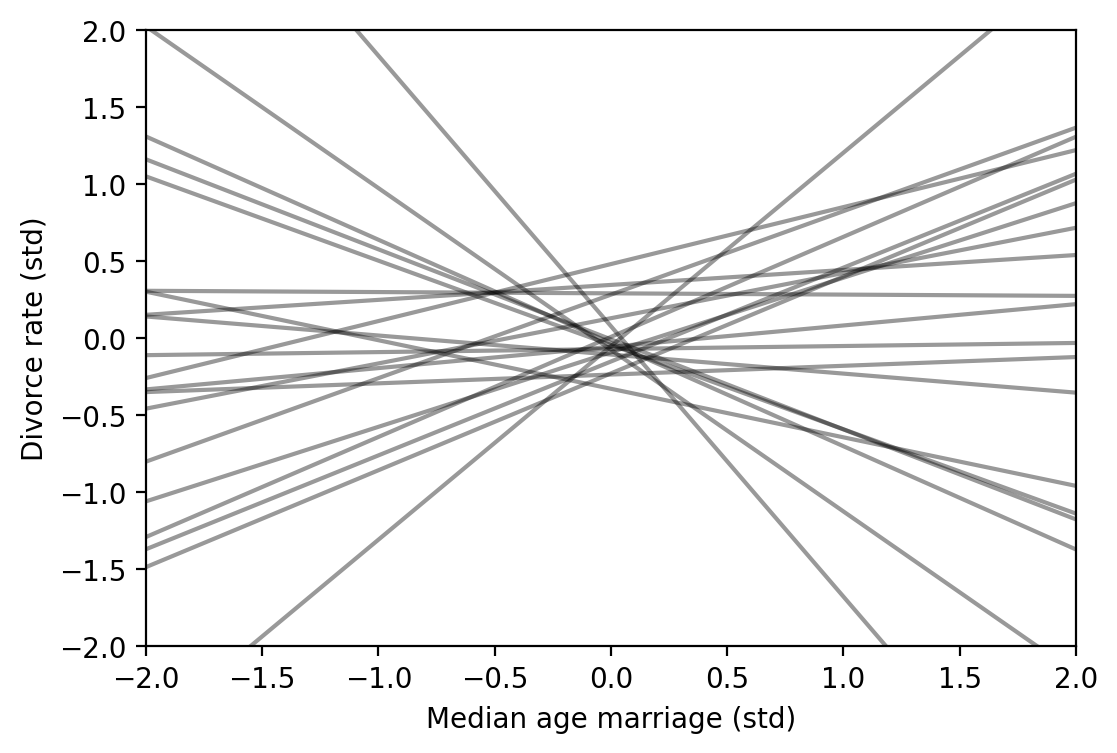

In [86]:
plt.subplot(xlim=(-2, 2), ylim=(-2, 2))
for i in range(20):
    plt.plot([-2, 2], mu[i], "k", alpha=0.4)
plt.xlabel("Median age marriage (std)")
plt.ylabel("Divorce rate (std)");

In [87]:
states_51

StructTuple(
  alpha=Array([-0.067218  ,  0.09717894,  0.09717894, -0.1045128 , -0.1045128 ,
           -0.1045128 , -0.09134048, -0.09134048,  0.12673783,  0.12673783,
            0.02063989,  0.01324556,  0.01324556, -0.0503146 ,  0.11724761,
           -0.00593441,  0.039805  , -0.03469146,  0.03469365,  0.04334452,
            0.04334452,  0.04334452,  0.04334452, -0.01516856, -0.01516856,
            0.0313106 , -0.17396303,  0.08866391, -0.05525352,  0.1509656 ,
            0.1509656 , -0.09463684,  0.03781796, -0.01418424, -0.01418424,
           -0.01418424,  0.01143697,  0.05513887,  0.05513887,  0.06799097,
           -0.03853859,  0.02782688,  0.01265384,  0.01265384,  0.01265384,
            0.03885379,  0.15261705,  0.15261705,  0.15261705, -0.00264779,
            0.16824603, -0.15416586, -0.15416586,  0.04183643, -0.06417295,
            0.12426381, -0.09598634,  0.12234123,  0.12234123,  0.12234123,
            0.12234123, -0.09548005, -0.09548005,  0.0315734 ,  0.03157

##### Code 5.6 

We can now model a simple regression for the Mariage rate as well.

In [90]:
d["M"] = d.Marriage.pipe(lambda x: (x - x.mean()) / x.std())

In [91]:
def model_52(marriage_rate_data):
    def _generator():
        alpha = yield tfd.Normal(loc=0.0, scale=0.2, name="alpha")
        betaM = yield tfd.Normal(loc=0.0, scale=0.5, name="betaM")
        sigma = yield tfd.Exponential(rate=1.0, name="sigma")
        mu = alpha + betaM * marriage_rate_data
        yield tfd.Normal(loc=mu, scale=sigma, name="divorce")

    return tfd.JointDistributionCoroutineAutoBatched(_generator, validate_args=True)

jd_52 = model_52(d.M.values)

#### Prior

In [179]:
*prior_params, prior_predictive = jd_52.sample(2500, seed=a_key())

In [180]:
prior_params

[Array([-0.22924867,  0.1710261 , -0.02979134, ...,  0.07094518,
        -0.12143139, -0.17507735], dtype=float32),
 Array([0.08191279, 0.46383247, 0.3612215 , ..., 0.4529986 , 0.14551044,
        0.85598266], dtype=float32),
 Array([0.7658116 , 0.16600601, 0.7300103 , ..., 0.02569541, 0.09715718,
        1.8743392 ], dtype=float32)]

In [ ]:
prior_predictive.shape

(2500, 50)

In [152]:
# arviz expects (chain, draw, *shape)
prior_trace = az.from_dict(
    observed_data={"divorce": d.D.values},
    prior_predictive={"divorce": prior_predictive[jnp.newaxis, ...]},
    # coords={"observation": jnp.arange(50)},
    # dims={"observations": ["observation"]},
)

print(prior_trace.prior_predictive)

<xarray.Dataset> Size: 520kB
Dimensions:        (chain: 1, draw: 2500, divorce_dim_0: 50)
Coordinates:
  * chain          (chain) int64 8B 0
  * draw           (draw) int64 20kB 0 1 2 3 4 5 ... 2495 2496 2497 2498 2499
  * divorce_dim_0  (divorce_dim_0) int64 400B 0 1 2 3 4 5 ... 44 45 46 47 48 49
Data variables:
    divorce        (chain, draw, divorce_dim_0) float32 500kB 0.0144 ... 0.5083
Attributes:
    created_at:     2024-06-19T13:12:30.175143+00:00
    arviz_version:  0.18.0


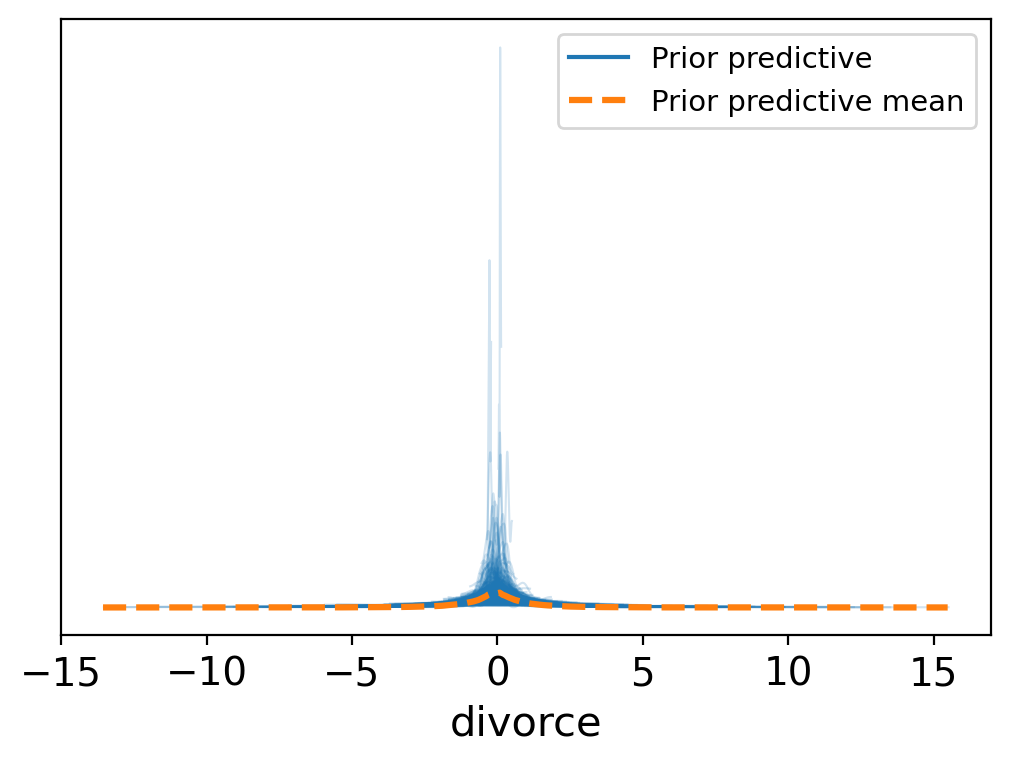

In [ ]:
az.plot_ppc(prior_trace, group="prior", num_pp_samples=500);

#### Posterior

In [141]:
# conditional sample: (betaM, sigma | alpha=0.2)
jd_52.sample(value=[0.2, None, None, None], seed=a_key())

StructTuple(
  alpha=Array(0.2, dtype=float32),
  betaM=Array(1.6419656, dtype=float32),
  sigma=Array(0.39289555, dtype=float32),
  divorce=Array([ 0.1356282 ,  2.8554718 ,  0.56621385,  2.7436047 ,  0.19073851,
            1.9652144 , -1.754112  ,  0.9991354 , -0.57454336, -1.3980854 ,
            1.2982901 ,  2.4740937 ,  2.7311497 , -0.992888  ,  0.13850805,
            1.2599614 ,  0.7107239 ,  1.3097813 ,  0.91296834, -2.0963268 ,
           -0.8217353 , -1.5558923 , -0.91139543, -1.9779117 ,  0.3290522 ,
           -0.70277643, -0.31515723, -0.01897921, -1.7888956 , -2.4288282 ,
            0.41514248, -1.0014454 ,  0.2327303 ,  2.4997826 , -1.5391577 ,
            1.9040382 , -0.15614651, -2.5230289 , -1.9284326 , -0.528813  ,
           -0.35243952,  0.54513353,  0.630811  ,  4.7066536 , -0.71745896,
            0.8442453 ,  1.3869064 ,  1.2987077 , -1.007875  ,  4.599514  ],      dtype=float32)
)

In [135]:
# conditional sample: (betaM, sigma | alpha=0.2)
jd_52.sample(alpha=0.2, seed=a_key())

StructTuple(
  alpha=Array(0.2, dtype=float32),
  betaM=Array(0.41656533, dtype=float32),
  sigma=Array(1.4824997, dtype=float32),
  divorce=Array([-0.3349238 ,  1.6702225 ,  2.8344243 , -1.5363097 ,  2.7437482 ,
           -0.46191847,  0.11664857, -0.87974083,  0.9835101 , -1.6645143 ,
           -0.04748991,  1.9378623 ,  0.1222195 , -3.0466003 , -0.5828819 ,
            1.4618074 ,  1.27688   ,  0.18508871, -0.20733282,  0.8529437 ,
            1.8208349 ,  0.5294172 , -2.2951176 , -0.77963233, -1.4148452 ,
            0.59587103,  0.8594248 ,  0.63986737,  0.7834483 ,  1.3912578 ,
           -2.061859  ,  0.64506465, -1.3021338 , -0.44113016,  1.0976515 ,
            0.13906127, -2.3040504 , -1.6245859 , -0.611477  ,  0.15001655,
            1.1879431 , -1.9790058 , -0.2929294 ,  1.9849842 ,  0.69123155,
            0.66916203,  1.9274731 , -1.111146  ,  2.0919363 ,  0.22172284],      dtype=float32)
)

In [136]:
# conditional distribution: (betaM, sigma | alpha=0.2)
jd_52.experimental_pin(alpha=0.2)

<tfp.distributions.JointDistributionPinned 'PinnedJointDistributionCoroutineAutoBatched' batch_shape=[] event_shape=StructTuple(
  betaM=[],
  sigma=[],
  divorce=[50]
) dtype=StructTuple(
  betaM=float32,
  sigma=float32,
  divorce=float32
)>

In [140]:
# conditional distribution: (betaM, sigma | alpha=0.2)
tfde = tfp.experimental.distributions
tfde.JointDistributionPinned(jd_52, alpha=0.2)

<tfp.distributions.JointDistributionPinned 'PinnedJointDistributionCoroutineAutoBatched' batch_shape=[] event_shape=StructTuple(
  betaM=[],
  sigma=[],
  divorce=[50]
) dtype=StructTuple(
  betaM=float32,
  sigma=float32,
  divorce=float32
)>

In [149]:
# conditional distribution i.e., posterior: (alpha, betaM, sigma | divorce)
jd_52_pd = jd_52.experimental_pin(divorce=d.D.values)

In [151]:
jd_52_pd.sample_unpinned(seed=a_key())

StructTuple(
  alpha=Array(0.22570153, dtype=float32),
  betaM=Array(-0.636363, dtype=float32),
  sigma=Array(2.349587, dtype=float32)
)

In [159]:
# from the official document:
# experimental_pin pins some parts, returning an unnormalized distribution object.
# The measure on the space of unpinned values that is represented by this object 
# is not a probability measure, 
# so the values of log_prob will in general not integrate to 1.
def target_log_prob_52(*states):
    return jd_52_pd.unnormalized_log_prob(states)

In [155]:
init_state_52 = jd_52_pd.sample_unpinned(seed=a_key())

In [156]:
num_burnin_steps = 500
num_results = 500
step_size = 0.1

In [160]:
kernel_52 = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=target_log_prob_52,
    step_size=step_size,
    num_leapfrog_steps=2)

kernel_52 = tfp.mcmc.SimpleStepSizeAdaptation(
    inner_kernel=kernel_52, num_adaptation_steps=int(num_burnin_steps * 0.8))

In [272]:
posterior_52 = tfp.mcmc.sample_chain(
    num_results=num_results,
    current_state=init_state_52,
    kernel=kernel_52,
    num_burnin_steps=num_burnin_steps,
    trace_fn=None,
    seed=a_key())

In [ ]:
## in case of multiple chains.
# tfp.mcmc.sample_chain output shape: (sample, batch, event)
#  == in terms of arviz, (draws, chains, *shape)
# arvis input shape: (chains, draws, *shape)
# states_51 = [jnp.moveaxis(s, 0, 1) for s in states_51]

In [163]:
posterior_52_dict = posterior_52._asdict()
az.summary(posterior_52_dict, round_to=2, kind="stats", hdi_prob=0.89)

mean    sd  hdi_5.5%  hdi_94.5%
alpha -0.00  0.11     -0.15       0.19
betaM  0.34  0.14      0.14       0.56
sigma  0.95  0.10      0.80       1.11

In [164]:
jd_52_pd._flat_resolve_names()

['alpha', 'betaM', 'sigma']

In [268]:
# now, easy to get posterior_predictive
M_seq = jnp.linspace(start=-3.0, stop=3.2, num=30)
jd_52_test = model_52(M_seq)
posteriors_52 = jd_52_test.sample(value=posterior_52, seed=a_key())

#### arviz settup

In [265]:
priors_52 = jd_52.sample(2000, seed=a_key())

In [266]:
# assume y (output) is at the end
y_slot = len(priors_52._fields) - 1
# keeping StructTuple type
prior_52, prior_predictive_52 = priors_52[: y_slot], priors_52[y_slot: ]

In [237]:
# arviz helper function
# arviz expects shapes to be of the form (chain, draw, *shape)
# prior usually does not have chain dim: (draw, *shape)
# add a dim at 0: (1, draw, *shape)
# output is dict
def add_chain_dim(prior_sample):
  return dict((k, jnp.expand_dims(v, axis=0)) \
              for k, v in prior_sample._asdict().items())

In [267]:
prior_52, prior_predictive_52 = add_chain_dim(prior_52), add_chain_dim(prior_predictive_52)

In [286]:
posterior_52, posterior_predictive_52 = posteriors_52[: y_slot], posteriors_52[y_slot: ]

In [287]:
posterior_52, posterior_predictive_52 = add_chain_dim(posterior_52), add_chain_dim(posterior_predictive_52)

In [298]:
idata_52 = az.from_dict(
  prior=prior_52, prior_predictive=prior_predictive_52,
  posterior=posterior_52, posterior_predictive=posterior_predictive_52,
  observed_data={"divorce": d.D.values},
  constant_data={"M": d.M.values})

In [293]:
az.summary(idata_52)

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha -0.001  0.109  -0.206    0.193      0.004    0.004     613.0     331.0   
betaM  0.343  0.136   0.113    0.611      0.008    0.005     327.0     350.0   
sigma  0.952  0.098   0.771    1.131      0.005    0.004     513.0     200.0   

       r_hat  
alpha    NaN  
betaM    NaN  
sigma    NaN

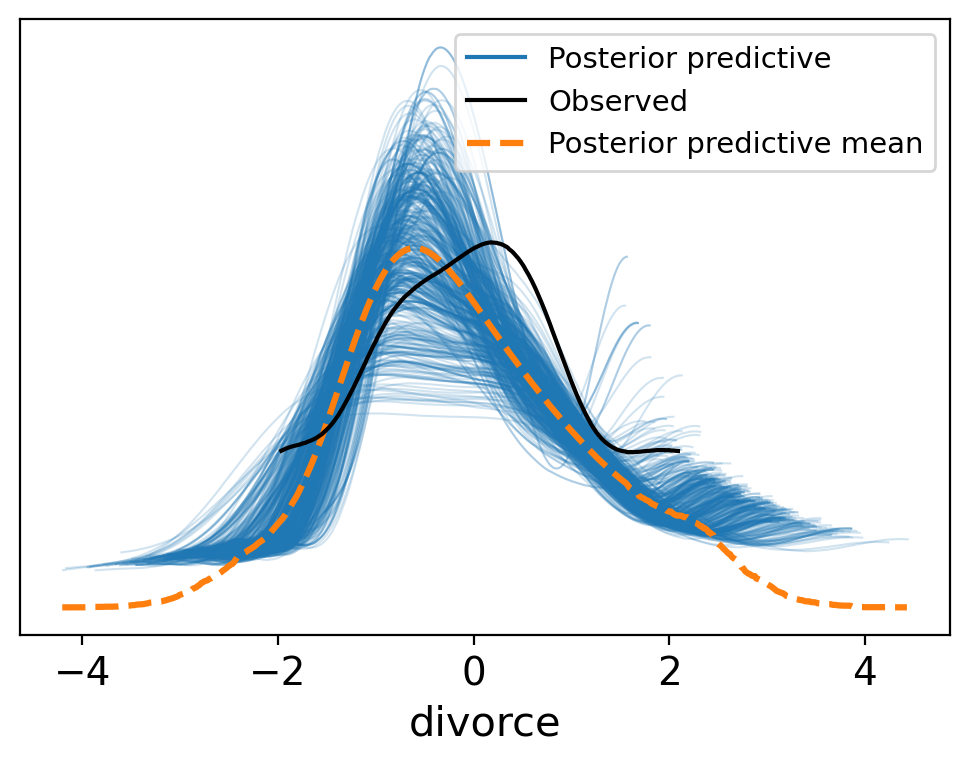

In [295]:
az.plot_ppc(idata_52, group="posterior", num_pp_samples=500);

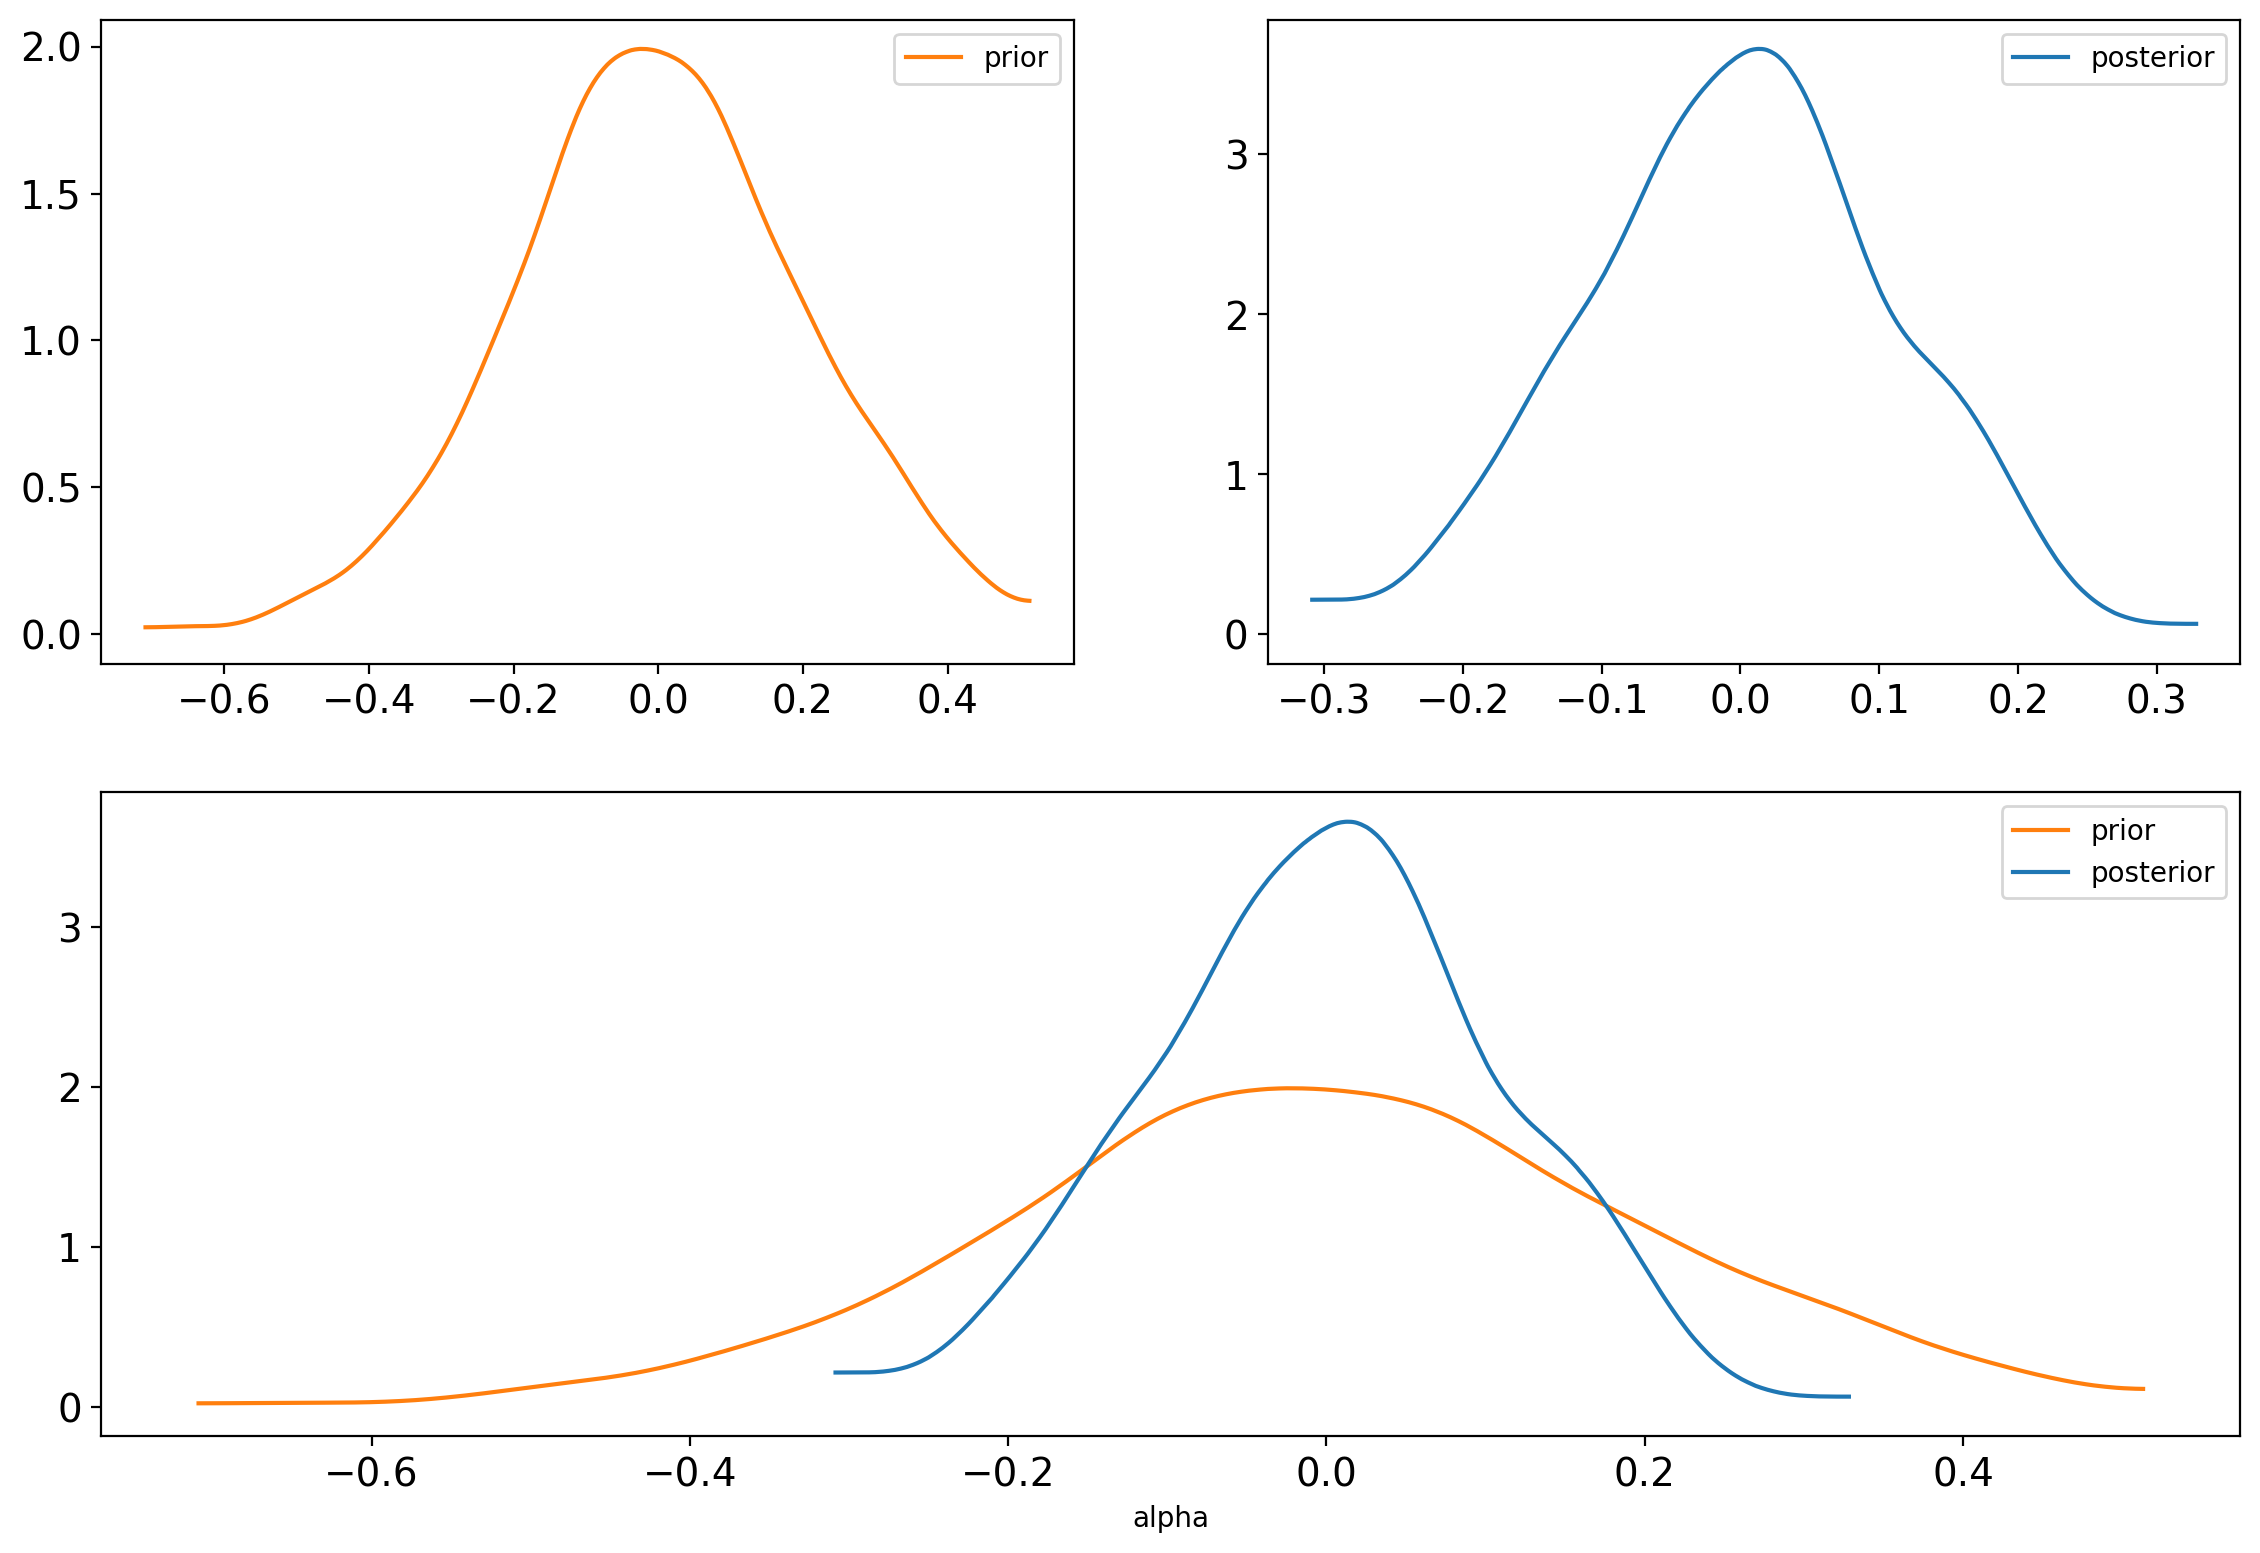

In [297]:
az.plot_dist_comparison(idata_52, var_names=["alpha"]);

##### Code 5.10

In [302]:
def model_53(median_age_data, marriage_rate_data):
    def _generator():
        alpha = yield tfd.Normal(loc=0.0, scale=0.2, name="alpha")
        betaA = yield tfd.Normal(loc=0.0, scale=0.5, name="betaA")
        betaM = yield tfd.Normal(loc=0.0, scale=0.5, name="betaM")
        sigma = yield tfd.Exponential(rate=1.0, name="sigma")
        mu = alpha + betaA * median_age_data + betaM * marriage_rate_data
        yield tfd.Normal(loc=mu, scale=sigma, name="divorce")

    return tfd.JointDistributionCoroutineAutoBatched(_generator, validate_args=True)

In [303]:
jd_53 = model_53(d.A.values, d.M.values)

In [307]:
# added a dimension for arviz: (1, draws)
priors_53 = jd_53.sample((1, 1000), seed=a_key())

In [308]:
# assume y (output) is at the end
y_slot = len(priors_53._fields) - 1
# keeping StructTuple type
prior_53, prior_predictive_53 = priors_53[: y_slot], priors_53[y_slot: ]

In [337]:
dict_53 = dict(
  prior=prior_53._asdict(), 
  prior_predictive=prior_predictive_53._asdict(),
  observed_data={"divorce": d.D.values})

In [338]:
idata_53 = az.from_dict(**dict_53)

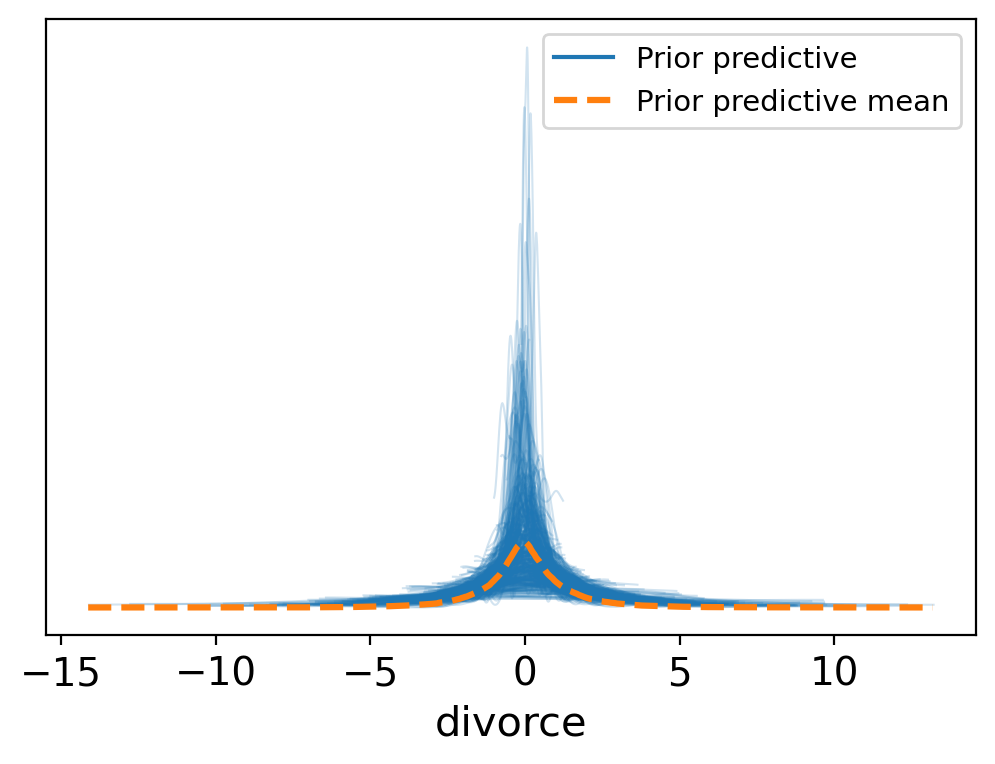

In [339]:
az.plot_ppc(idata_53, group="prior", num_pp_samples=500);

#### Posterior

In [340]:
# conditional distribution i.e., posterior: (alpha, betaM, sigma | divorce)
jd_53_pd = jd_53.experimental_pin(divorce=d.D.values)

In [343]:
# from the official document:
# experimental_pin pins some parts, returning an unnormalized distribution object.
# The measure on the space of unpinned values that is represented by this object 
# is not a probability measure, 
# so the values of log_prob will in general not integrate to 1.
def target_log_prob_53(*states):
    return jd_53_pd.unnormalized_log_prob(states)

In [348]:
# 4 chains
init_state_53 = jd_53_pd.sample_unpinned(4, seed=a_key())

In [ ]:
num_burnin_steps = 500
num_results = 500
step_size = 0.1

In [345]:
kernel_53 = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=target_log_prob_53,
    step_size=step_size,
    num_leapfrog_steps=2)

kernel_53 = tfp.mcmc.SimpleStepSizeAdaptation(
    inner_kernel=kernel_53, num_adaptation_steps=int(num_burnin_steps * 0.8))

In [349]:
posteriors_53 = tfp.mcmc.sample_chain(
    num_results=num_results,
    current_state=init_state_53,
    kernel=kernel_53,
    num_burnin_steps=num_burnin_steps,
    trace_fn=None,
    seed=a_key())

In [352]:
# (draws, chains) --> (chains, draws)
posteriors_53_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in posteriors_53._asdict().items()}

In [357]:
pp_53 = jd_53.sample(value=posteriors_53, seed=a_key())

In [365]:
y_slot = len(pp_53._fields) - 1
posterior_predictive_53 = pp_53[y_slot: ]
posterior_predictive_53_dict = {k: jnp.moveaxis(v, 0, 1) \
                                for k, v in posterior_predictive_53._asdict().items()}

In [366]:
dict_53.update(posterior=posteriors_53_dict,
               posterior_predictive=posterior_predictive_53._asdict())

In [367]:
idata_53 = az.from_dict(**dict_53)

In [368]:
az.summary(idata_53)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha  0.000  0.102  -0.207    0.175      0.002    0.002    2234.0    1222.0   
betaA -0.600  0.160  -0.884   -0.299      0.008    0.005     430.0     608.0   
betaM -0.050  0.159  -0.372    0.216      0.007    0.005     521.0     845.0   
sigma  0.827  0.091   0.669    0.997      0.002    0.002    1520.0     564.0   

       r_hat  
alpha   1.00  
betaA   1.02  
betaM   1.01  
sigma   1.01

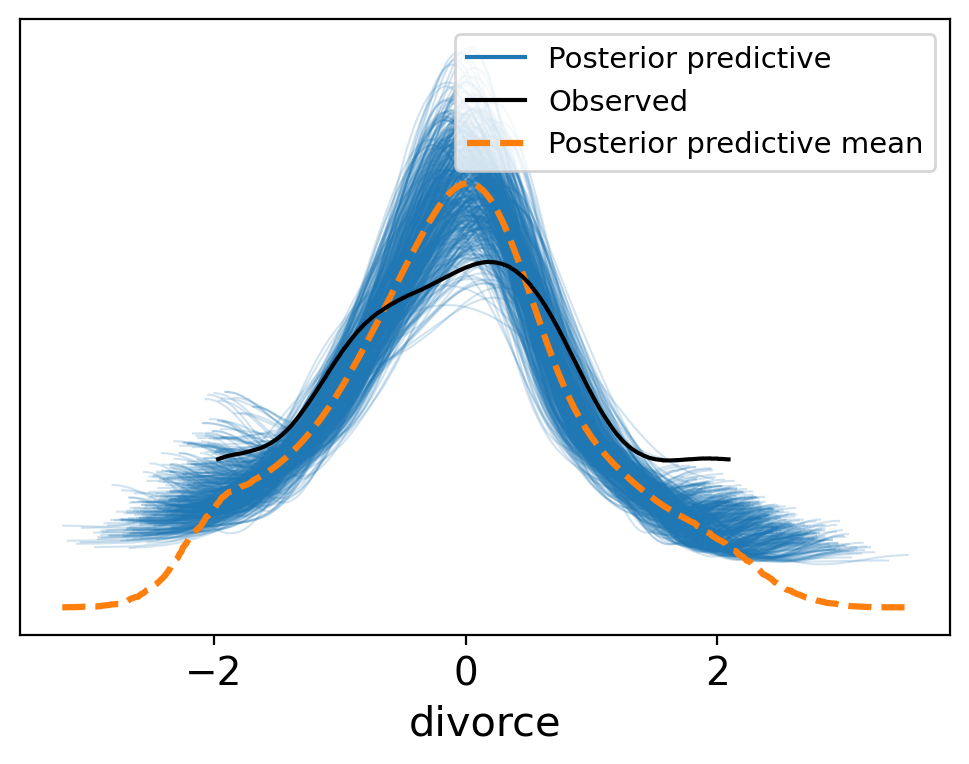

In [369]:
az.plot_ppc(idata_53, group="posterior", num_pp_samples=500);

Let's try to understand the above table generated by arviz.

In the model above, we had include both the predictors i.e. M & A. The weights of M i.e. betaM is approaching zero where as betaA is more or less unchanged.


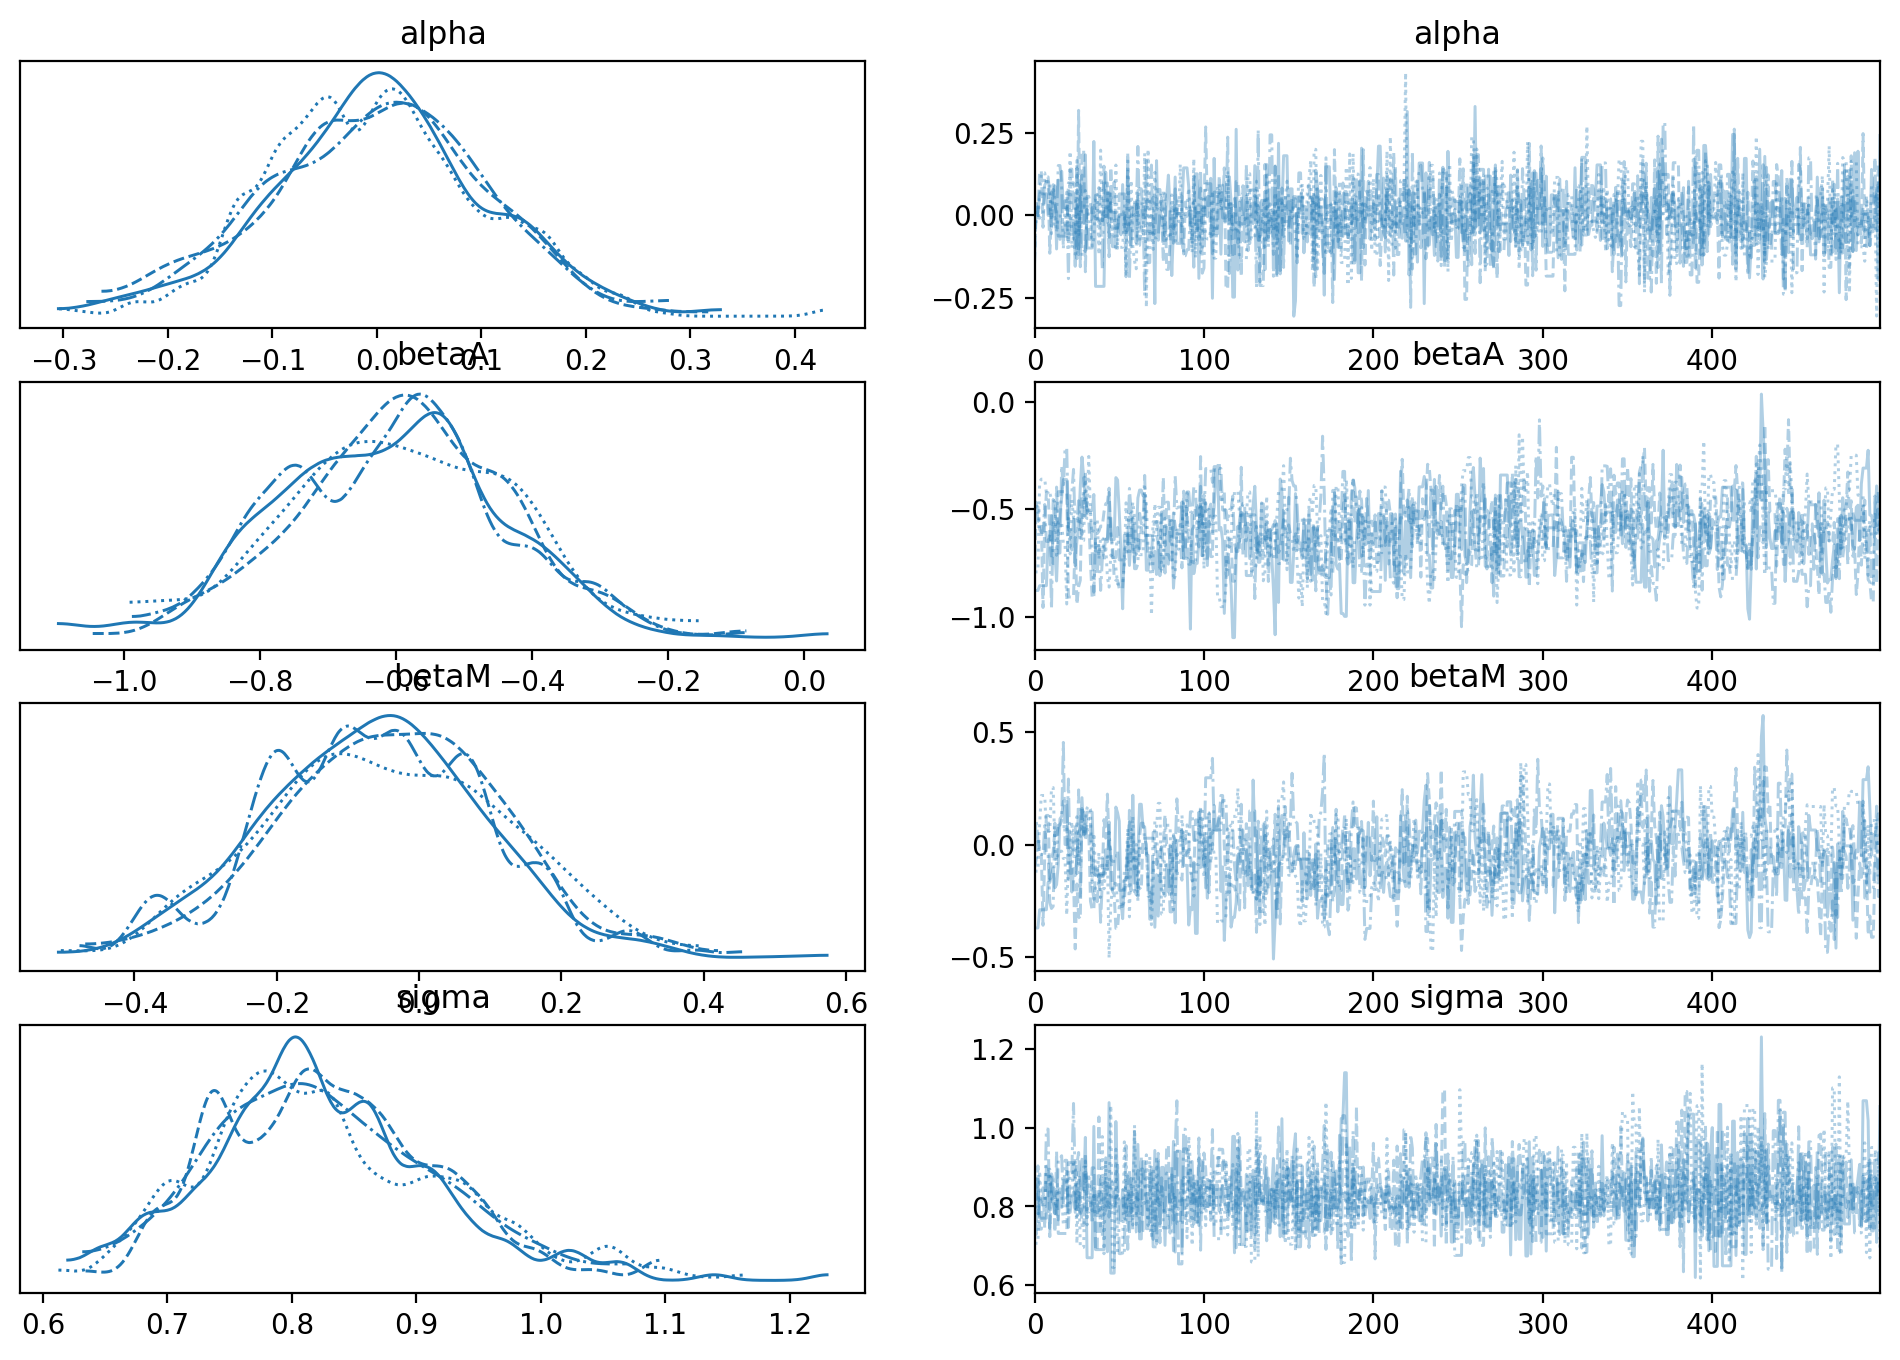

In [371]:
az.plot_trace(idata_53);

##### Code 5.11

Here we will take the help of forest plot to compare the posteriors of various models that we have built so far

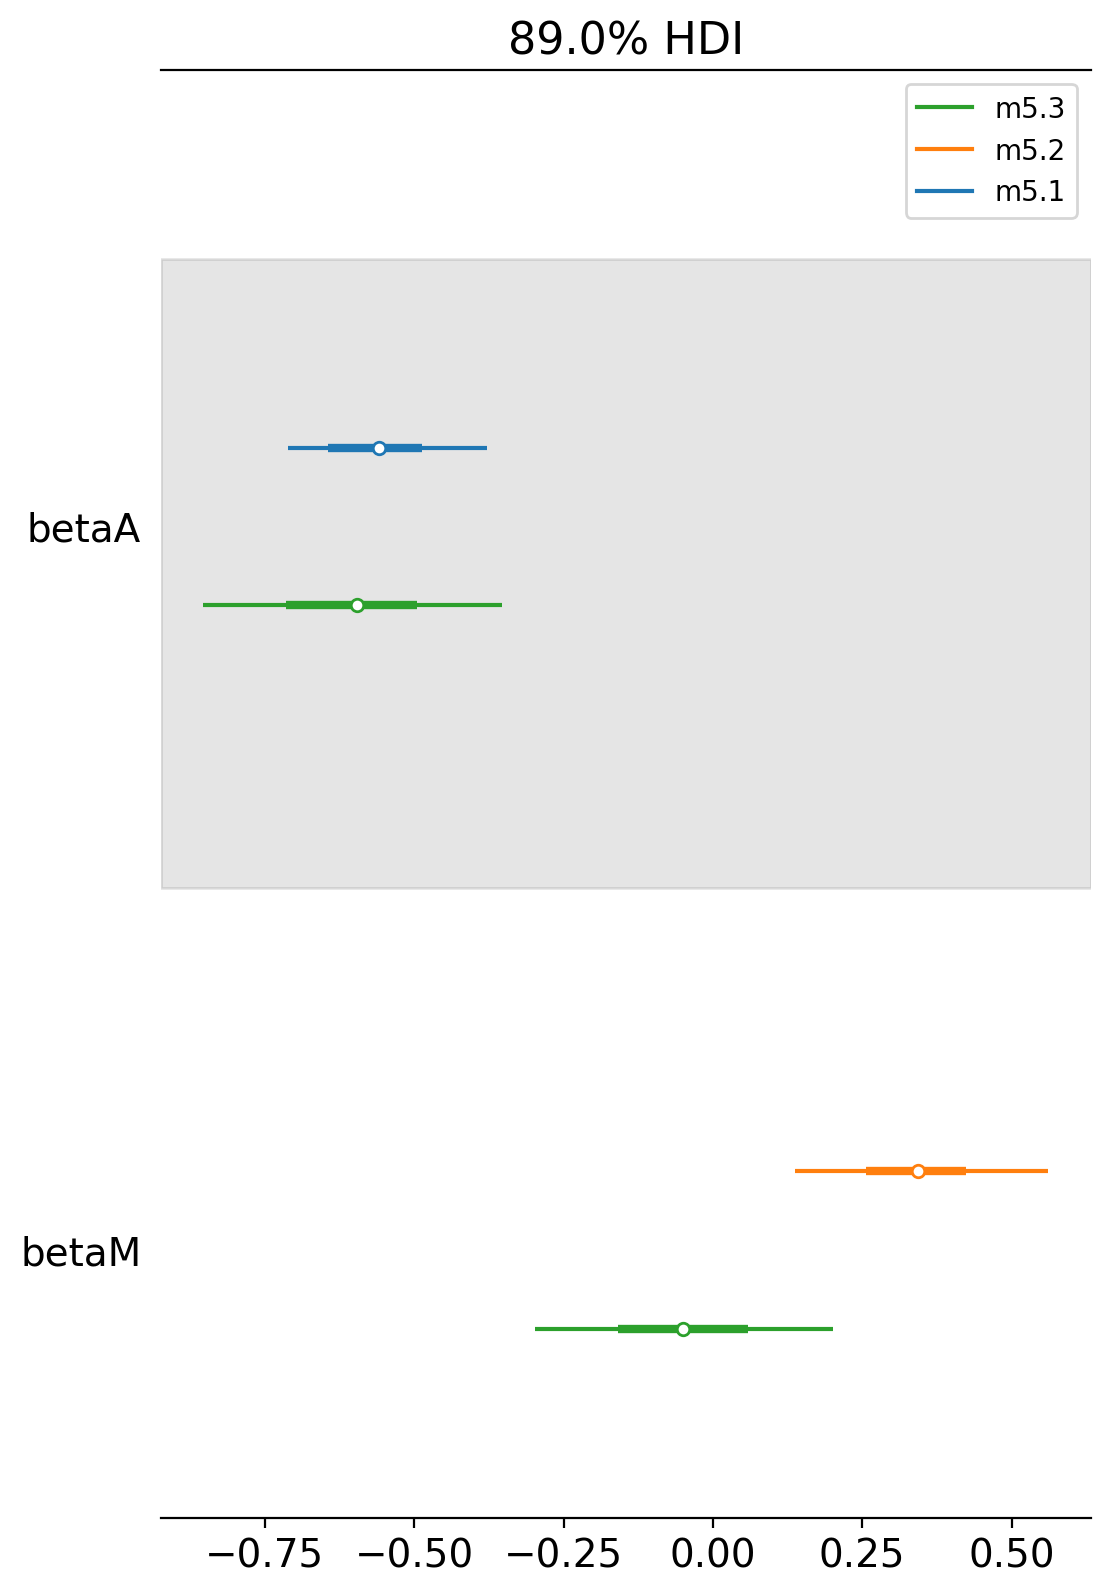

In [373]:
coeftab = {"m5.1": states_51_dict, "m5.2": idata_52, "m5.3": idata_53}

az.plot_forest(
    list(coeftab.values()),
    model_names=list(coeftab.keys()),
    combined=True,
    var_names=["betaA", "betaM"],
    hdi_prob=0.89,
);

Let's learn how to read above plot

m5.1 is our first model where we had used betaA. If we compare it to m5.3 it is more or less at the same place.

whereas,

m5.2 is our second model where we had used betaM. If we compare it to m5.3, it is now closer to zero. 

This is another way to read/plot what we saw in the arviz summary in Code 5.10


From all this, we can say that - once we know median age at marriage for a State, there is little or no additional predictive power in also knowing the rate of marriage in that state

##### Code 5.27

Previous example used multiple predictors to show case spurious association but sometimes you do need multiple predictor variables as they do have influence on the outcome.

It is possible that one predictor variable is +ively related to outcome whereas the other one is -ively correlated.

We are going to use a new dataset called Milk.

Question that we want to answer is - **To what extent energy content of milk, measured in KCal, is related to the percent of the brain mass that is neocortex**.



In [3]:
d = RethinkingDataset.Milk.get_dataset()
d.head()

clade         species  kcal.per.g  perc.fat  perc.protein  \
0  Strepsirrhine  Eulemur fulvus        0.49     16.60         15.42   
1  Strepsirrhine        E macaco        0.51     19.27         16.91   
2  Strepsirrhine        E mongoz        0.46     14.11         16.85   
3  Strepsirrhine   E rubriventer        0.48     14.91         13.18   
4  Strepsirrhine     Lemur catta        0.60     27.28         19.50   

   perc.lactose  mass  neocortex.perc  
0         67.98  1.95           55.16  
1         63.82  2.09             NaN  
2         69.04  2.51             NaN  
3         71.91  1.62             NaN  
4         53.22  2.19             NaN

* kcal.per.g - Kilocalories of energy per gram of milk
* mass - Average female body mass, in KG
* neocortex.perc - Percent of total brain mass that is neocortex mass

Although not mentioned in the question that was asked above, we are considering the female body mass as well. This is to see the masking that hides the relationships among the variables.


## 5.2 Masked relationship

##### Code 5.28

In [4]:
d["K"] = d["kcal.per.g"].pipe(lambda x: (x - x.mean()) / x.std())
d["N"] = d["neocortex.perc"].pipe(lambda x: (x - x.mean()) / x.std())
d["M"] = d.mass.pipe(np.log).pipe(lambda x: (x - x.mean()) / x.std())

##### Code 5.29

A Simple Bivariate model between KCal and NeoCortex percent

In [378]:
def model_55(neocortex_percent_std):
    def _generator():
        alpha = yield tfd.Normal(loc=0.0, scale=1.0, name="alpha")
        betaN = yield tfd.Normal(loc=0.0, scale=1.0, name="betaN")
        sigma = yield tfd.Exponential(rate=1.0, name="sigma")
        mu = alpha + betaN * neocortex_percent_std
        yield tfd.Normal(loc=mu, scale=sigma, name="K")

    return tfd.JointDistributionCoroutineAutoBatched(_generator, validate_args=True)

In [379]:
jd_55 = model_55(d.N.values)

In [380]:
samples = jd_55.sample(seed=a_key())
samples

StructTuple(
  alpha=Array(-0.88489467, dtype=float32),
  betaN=Array(1.0666411, dtype=float32),
  sigma=Array(1.7393258, dtype=float32),
  K=Array([-3.4858234 ,         nan,         nan,         nan,         nan,
           -0.6786466 , -1.7812319 , -0.16584873,         nan,  1.8613524 ,
           -1.36528   , -0.9680392 , -4.610798  ,         nan,         nan,
           -2.3774633 ,         nan, -1.8526453 ,         nan, -1.4153104 ,
                   nan, -1.0069461 ,         nan, -2.753888  ,  2.5995154 ,
                   nan, -1.1184729 ,  1.5532658 , -2.136926  ], dtype=float32)
)

If you see above displayed samples, you would see lot of NaN. Now tensorflow prob does not complain and/or throw
an exception here but it is going to cause lot of pain.

In other words, we must not have this situation i.e. presence of NaN

##### Code 5.30

In [381]:
d["neocortex.perc"]

0     55.16
1       NaN
2       NaN
3       NaN
4       NaN
5     64.54
6     64.54
7     67.64
8       NaN
9     68.85
10    58.85
11    61.69
12    60.32
13      NaN
14      NaN
15    69.97
16      NaN
17    70.41
18      NaN
19    73.40
20      NaN
21    67.53
22      NaN
23    71.26
24    72.60
25      NaN
26    70.24
27    76.30
28    75.49
Name: neocortex.perc, dtype: float64

We have lot of data missing in the neorcortex.perc colums

##### Code 5.31

Drop all the cases with missing values. This is known as **COMPLETE CASE ANANLYSIS**

In [5]:
dcc = d.iloc[d[["K", "N", "M"]].dropna(how="any", axis=0).index]

# we now have only 17 rows
dcc.describe()

kcal.per.g   perc.fat  perc.protein  perc.lactose       mass  \
count   17.000000  17.000000     17.000000     17.000000  17.000000   
mean     0.657647  36.063529     16.255294     47.681176  16.637647   
std      0.172899  14.705419      5.598480     13.585261  23.582322   
min      0.460000   3.930000      7.370000     27.090000   0.120000   
25%      0.490000  27.180000     11.680000     37.800000   1.550000   
50%      0.620000  37.780000     15.800000     46.880000   5.250000   
75%      0.800000  50.490000     20.850000     55.200000  33.110000   
max      0.970000  55.510000     25.300000     70.770000  79.430000   

       neocortex.perc          K             N          M  
count       17.000000  17.000000  1.700000e+01  17.000000  
mean        67.575882   0.098654 -2.821273e-15   0.033852  
std          5.968612   1.071235  1.000000e+00   1.138400  
min         55.160000  -1.125913 -2.080196e+00  -2.097830  
25%         64.540000  -0.940041 -5.086413e-01  -0.591039  
50%         68.850000  -0.134597  2.134697e-01   0.127441  
75%         71.260000   0.980633  6.172487e-01   1.212020  
max         76.300000   2.033906  1.461666e+00   1.727359

##### Code 5.32

In [383]:
jd_55_draft = model_55(dcc.N.values)
samples = jd_55_draft.sample(seed=a_key())
samples

StructTuple(
  alpha=Array(0.4998879, dtype=float32),
  betaN=Array(-0.50647724, dtype=float32),
  sigma=Array(0.63604254, dtype=float32),
  K=Array([ 1.59395   ,  1.3249516 ,  0.5730453 ,  1.0968063 ,  0.2165868 ,
            1.8525381 ,  0.27050722,  1.6070457 ,  0.8671568 ,  0.59876764,
            0.33487585, -0.24883658,  1.0314769 , -0.50451607,  0.03959125,
            0.5277393 , -0.01440145], dtype=float32)
)

You should not see an NaN in the samples

##### Code 5.33

Investigate if we have proper priors by plotting 50 prior regression lines

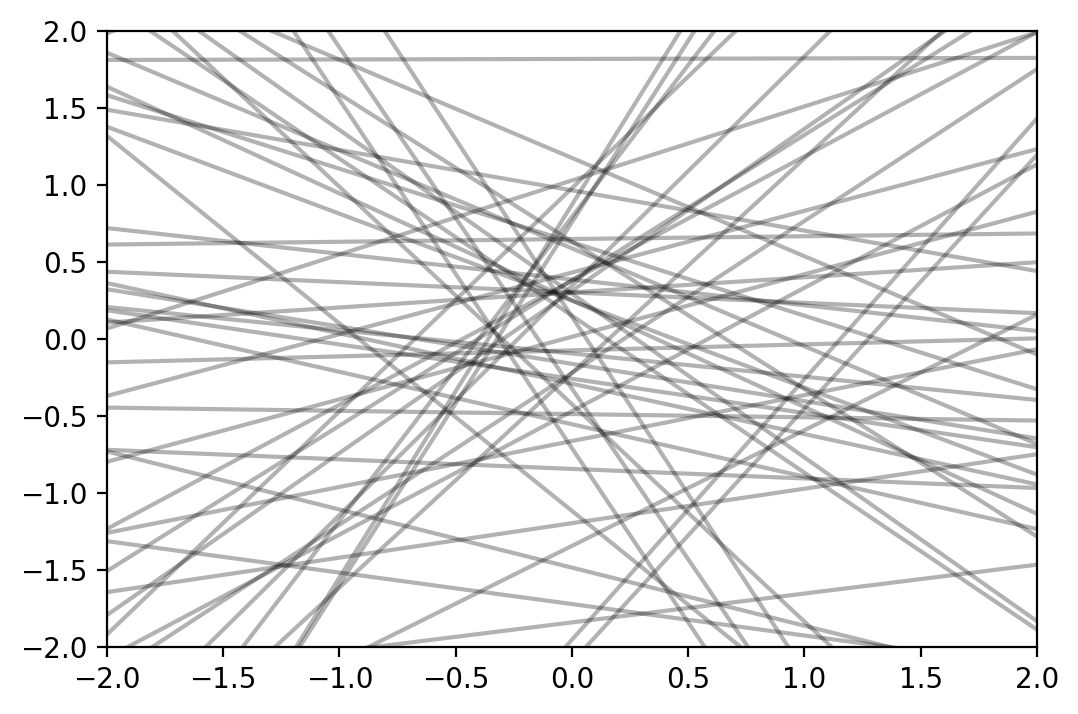

In [391]:
xseq = jnp.array([-2.0, 2.0])
sample_alpha, sample_betaN, *_ = model_55(xseq).sample(50, seed=a_key())

# we simply compute for the two possible values
mu_pred_0 = sample_alpha + sample_betaN * -2.0
mu_pred_1 = sample_alpha + sample_betaN * 2.0

mu_pred = jnp.column_stack([mu_pred_0, mu_pred_1])

plt.subplot(xlim=xseq, ylim=xseq)
for i in range(50):
    plt.plot(xseq, mu_pred[i], "k", alpha=0.3)

Above does not look good. We should have better priors for $\alpha$ so that it sticks closer to zero

##### Code 5.34

In [7]:
def model_55(neocortex_percent_std):
    def _generator():
        alpha = yield tfd.Normal(loc=0.0, scale=0.2, name="alpha")
        betaN = yield tfd.Normal(loc=0.0, scale=0.5, name="betaN")
        sigma = yield tfd.Exponential(rate=1.0, name="sigma")
        mu = alpha + betaN * neocortex_percent_std
        yield tfd.Normal(loc=mu, scale=sigma, name="K")

    return tfd.JointDistributionCoroutineAutoBatched(_generator, validate_args=True)

In [8]:
jd_55 = model_55(dcc.N.values)

In [10]:
# added a dimension for arviz: (1, draws)
pri_55 = jd_55.sample((1, 1000), seed=a_key())

In [11]:
# assume y (output) is at the end
y_slot = len(pri_55._fields) - 1
# keeping StructTuple type
prior_55, prior_predictive_55 = pri_55[: y_slot], pri_55[y_slot: ]

In [12]:
dict_55 = dict(
  prior=prior_55._asdict(), 
  prior_predictive=prior_predictive_55._asdict(),
  observed_data={"K": dcc.K.values})

In [401]:
idata_55 = az.from_dict(**dict_55)

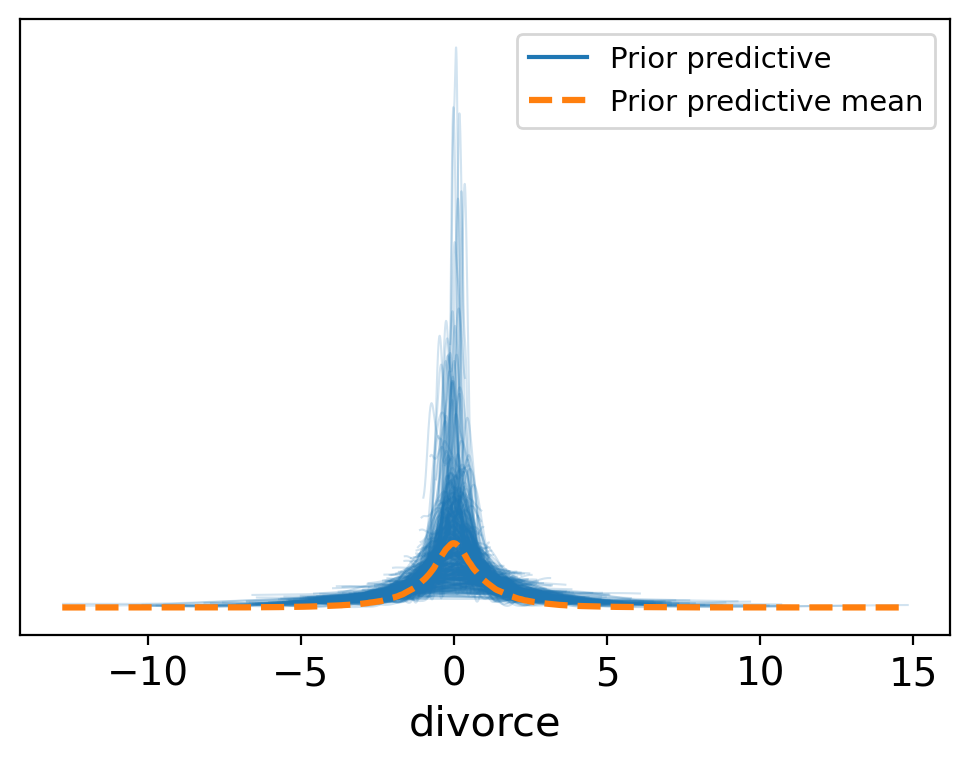

In [416]:
az.plot_ppc(idata_53, group="prior", num_pp_samples=500);

#### Posterior

In [13]:
jd_55_pd = jd_55.experimental_pin(K=dcc.K.values)

In [14]:
def target_log_prob_55(*states):
    return jd_55_pd.unnormalized_log_prob(states)

In [15]:
# 4 chains
init_state_55 = jd_55_pd.sample_unpinned(4, seed=a_key())

In [16]:
num_burnin_steps = 600
num_results = 600
step_size = 0.1

In [17]:
kernel_55 = tfp.mcmc.SimpleStepSizeAdaptation(
    inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=target_log_prob_55,
        step_size=step_size,
        num_leapfrog_steps=2), 
    num_adaptation_steps=int(num_burnin_steps * 0.8))

In [18]:
post_55 = tfp.mcmc.sample_chain(
    num_results=num_results,
    current_state=init_state_55,
    kernel=kernel_55,
    num_burnin_steps=num_burnin_steps,
    trace_fn=None,
    seed=a_key())

In [19]:
# (draws, chains) --> (chains, draws)
post_55_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_55._asdict().items()}

In [20]:
posterior_predictive_55 = jd_55.sample(value=post_55, seed=a_key())[y_slot: ]

In [21]:
posterior_predictive_55_dict = {k: jnp.moveaxis(v, 0, 1) for k, v \
                                in posterior_predictive_55._asdict().items()}

In [22]:
dict_55.update(posterior=post_55_dict,
               posterior_predictive=posterior_predictive_55_dict)

In [23]:
idata_55 = az.from_dict(**dict_55)

In [430]:
az.summary(idata_55)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha  0.037  0.166  -0.277    0.353      0.003    0.004    3403.0    1495.0   
betaN  0.127  0.250  -0.378    0.553      0.009    0.006     819.0    1097.0   
sigma  1.110  0.197   0.760    1.461      0.005    0.004    1550.0    1178.0   

       r_hat  
alpha    1.0  
betaN    1.0  
sigma    1.0

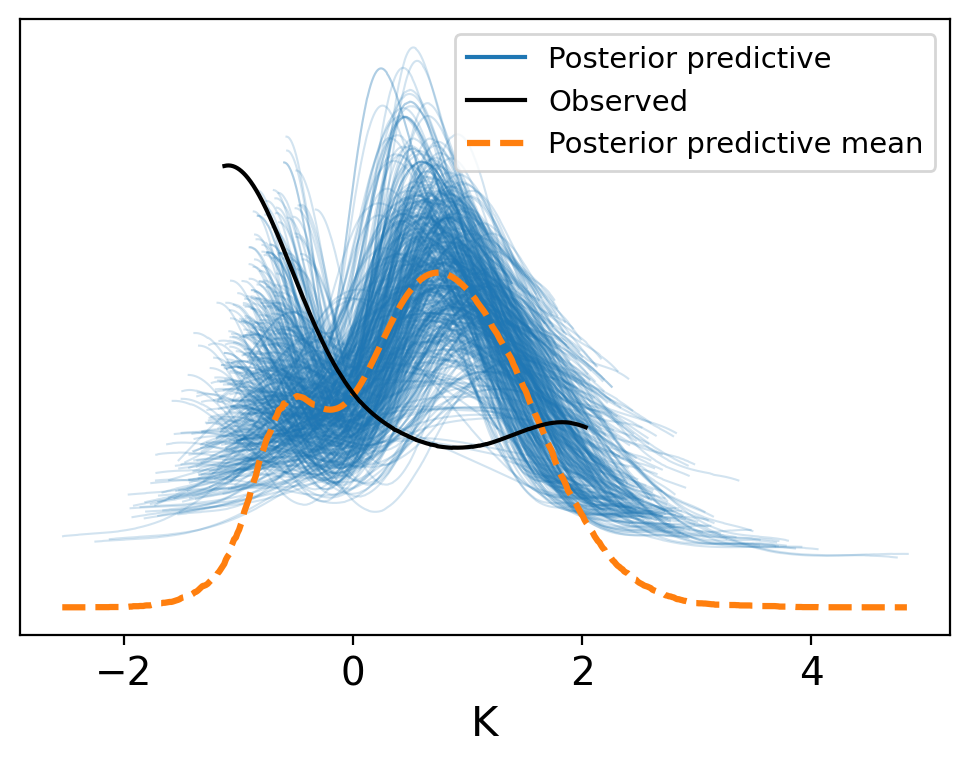

In [431]:
az.plot_ppc(idata_55, group="posterior", num_pp_samples=500);

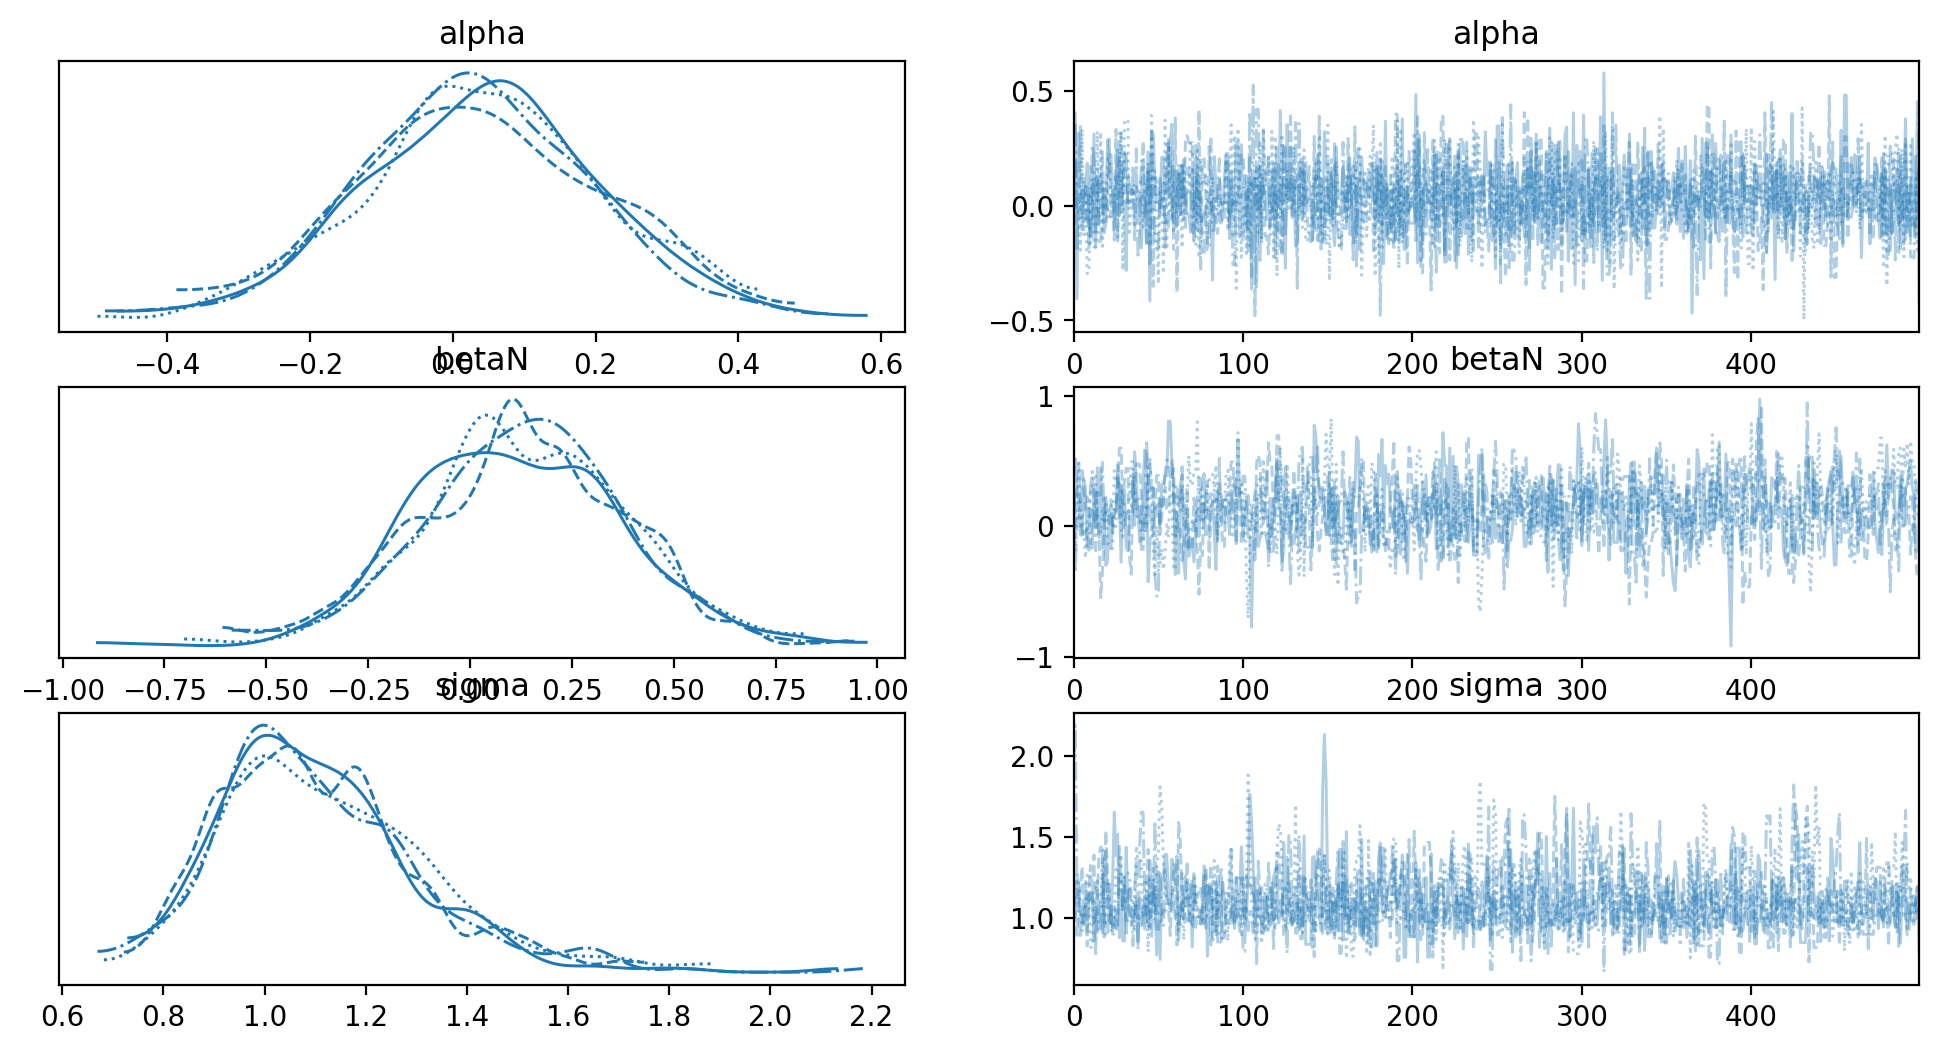

In [432]:
az.plot_trace(idata_55);

##### Code 5.37

We now consider another predictor variable; the adult female body mass

In [24]:
def model_56(female_body_mass):
    def _generator():
        alpha = yield tfd.Normal(loc=0.0, scale=0.2, name="alpha")
        betaM = yield tfd.Normal(loc=0.0, scale=0.5, name="betaM")
        sigma = yield tfd.Exponential(rate=1.0, name="sigma")
        mu = alpha + betaM * female_body_mass
        yield tfd.Normal(loc=mu, scale=sigma, name="K")

    return tfd.JointDistributionCoroutineAutoBatched(_generator, validate_args=True)

In [25]:
jd_56 = model_56(dcc.M.values)

In [26]:
jd_56_pd = jd_56.experimental_pin(K=dcc.K.values)

In [27]:
def target_log_prob_56(*states):
    return jd_56_pd.unnormalized_log_prob(states)

In [28]:
# 4 chains
init_state_56 = jd_56_pd.sample_unpinned(4, seed=a_key())

In [ ]:
num_burnin_steps = 600
num_results = 600
step_size = 0.1

In [29]:
kernel_56 = tfp.mcmc.SimpleStepSizeAdaptation(
    inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=target_log_prob_56,
        step_size=step_size,
        num_leapfrog_steps=2), 
    num_adaptation_steps=int(num_burnin_steps * 0.8))

In [30]:
post_56 = tfp.mcmc.sample_chain(
    num_results=num_results,
    current_state=init_state_56,
    kernel=kernel_56,
    num_burnin_steps=num_burnin_steps,
    trace_fn=None, seed=a_key())

In [31]:
# (draws, chains) --> (chains, draws)
post_56_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_56._asdict().items()}

In [32]:
dict_56 = dict(posterior=post_56_dict)

In [33]:
idata_56 = az.from_dict(**dict_56)

In [34]:
az.summary(idata_56)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha  0.034  0.157  -0.256    0.326      0.011    0.008     210.0     359.0   
betaM -0.247  0.204  -0.611    0.162      0.018    0.013     134.0     299.0   
sigma  1.052  0.181   0.738    1.411      0.013    0.010     200.0     256.0   

       r_hat  
alpha   1.02  
betaM   1.03  
sigma   1.01

Log-mass is negatively correlated with KCal. The influence is stronger than that of neocortex percent but it is in the opposite direction.

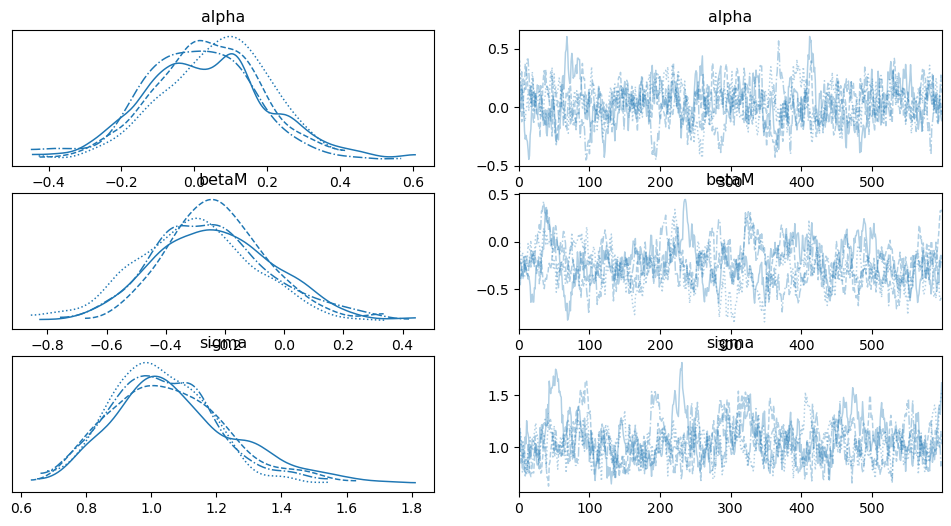

In [85]:
az.plot_trace(idata_56);

##### Code 5.38

Now let's see what happens when we add both the predictor variables to the model

In [2]:
def model_57(neocortex_percent_std, female_body_mass):
    def _generator():
        alpha = yield tfd.Normal(loc=0.0, scale=0.2, name="alpha")
        betaN = yield tfd.Normal(loc=0.0, scale=0.5, name="betaN")
        betaM = yield tfd.Normal(loc=0.0, scale=0.5, name="betaM")
        sigma = yield tfd.Exponential(rate=1.0, name="sigma")
        mu = alpha + betaN * neocortex_percent_std + betaM * female_body_mass
        K = yield tfd.Normal(loc=mu, scale=sigma, name="K")
        
    return tfd.JointDistributionCoroutineAutoBatched(_generator, validate_args=True)

In [6]:
jd_57 = model_57(dcc.N.values, dcc.M.values)

In [36]:
jd_57_pd = jd_57.experimental_pin(K=dcc.K.values)

In [37]:
def target_log_prob_57(*states):
    return jd_57_pd.unnormalized_log_prob(states)

In [38]:
# 4 chains
init_state_57 = jd_57_pd.sample_unpinned(4, seed=a_key())

In [ ]:
num_burnin_steps = 600
num_results = 600
step_size = 0.1

In [39]:
kernel_57 = tfp.mcmc.SimpleStepSizeAdaptation(
    inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=target_log_prob_57,
        step_size=step_size,
        num_leapfrog_steps=2), 
    num_adaptation_steps=int(num_burnin_steps * 0.8))

In [40]:
post_57 = tfp.mcmc.sample_chain(
    num_results=num_results,
    current_state=init_state_57,
    kernel=kernel_57,
    num_burnin_steps=num_burnin_steps,
    trace_fn=None, seed=a_key())

In [41]:
# (draws, chains) --> (chains, draws)
post_57_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_57._asdict().items()}

In [60]:
dict_57 = dict(posterior=post_57_dict,
               observed_data={"K": dcc.K.values})
idata_57 = az.from_dict(**dict_57)

In [61]:
# bad model
az.summary(idata_57)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha  0.019  0.136  -0.209    0.292      0.034    0.025      16.0      60.0   
betaM -0.481  0.193  -0.806   -0.087      0.068    0.050       9.0      13.0   
betaN  0.294  0.294  -0.196    0.894      0.128    0.096       5.0      13.0   
sigma  1.051  0.283   0.642    1.642      0.122    0.092       6.0      14.0   

       r_hat  
alpha   1.22  
betaM   1.35  
betaN   2.02  
sigma   1.83

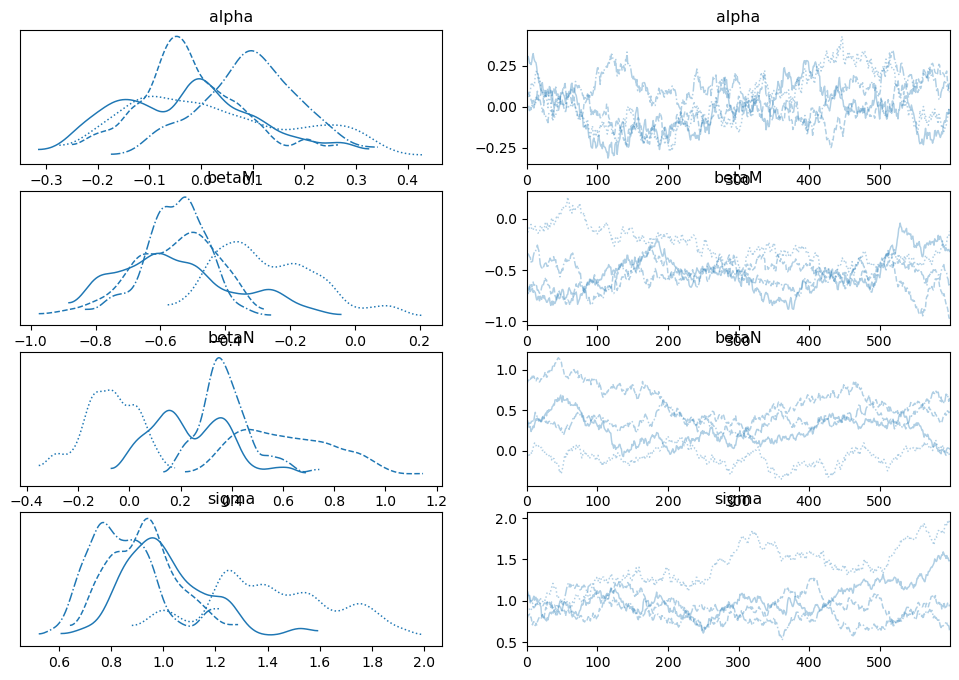

In [84]:
az.plot_trace(idata_57);

##### Code 5.39

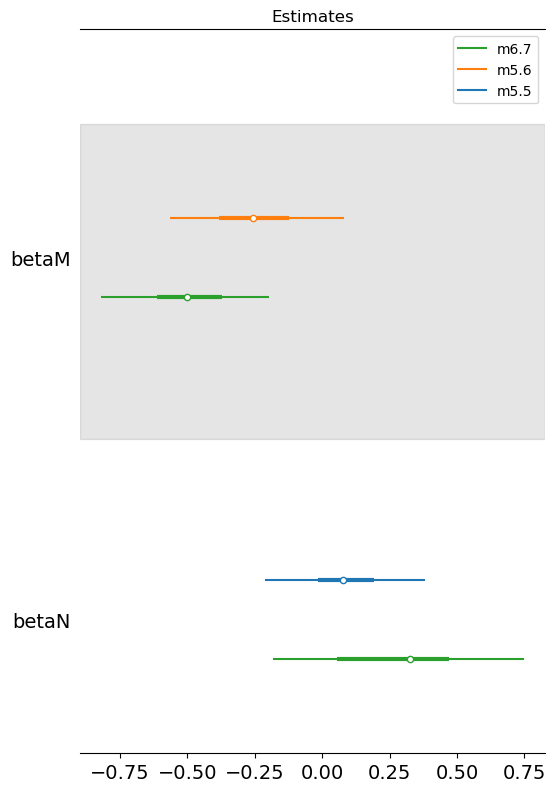

In [47]:
axes = az.plot_forest(
    [idata_55, idata_56, idata_57],
    model_names=["m5.5", "m5.6", "m6.7"],
    combined=True,
    var_names=["betaM", "betaN"],
    hdi_prob=0.89)

axes[0].set_title("Estimates");

##### Code 5.40

Counterfactual plot when setting N to zero and using M as the predictor variable 

In [48]:
import xarray

In [55]:
Mseq = xarray.DataArray(np.linspace(dcc.M.min() - 0.15, dcc.M.max() + 0.15, 30))

In [62]:
mu = idata_57.posterior["alpha"] + idata_57.posterior["betaM"] * Mseq
mu_mean = mu.mean(dim=["chain", "draw"])

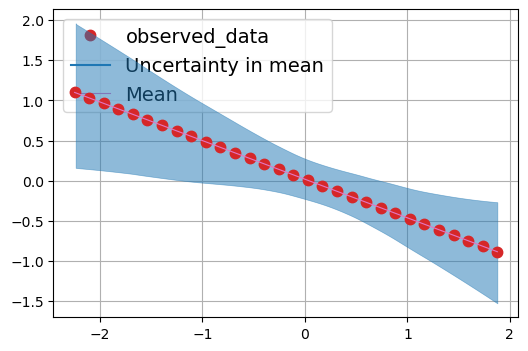

In [87]:
az.plot_lm(y=mu_mean, x=Mseq, y_model=mu,
           kind_pp="hdi", kind_model="hdi");

##### Code 5.44

This section discusses Categorical Variables i.e. Discrete & Unordered variables.

We will again use HOWELL dataset here. In previous chapter, we had taken into consider *sex* variable and here we will model it as a categorical variable.

To start with let's load the dataset

In [88]:
d = RethinkingDataset.Howell1.get_dataset()
d.head()

height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041914  41.0     1
4  145.415  41.276872  51.0     0

## 5.3 Categorical variables

##### Code 5.45


Here we are considering following model

$h_i \sim Normal(\mu_i,\sigma)$    

$\mu_i = \alpha + \beta_mm_i$   

$\alpha \sim Normal(178,20)$       

$\beta_m \sim Normal(0,10)$          

$\sigma \sim Exponential(1)$ 


*m* here is a categorical value and is 1 when we are dealing with males. This means that $\alpha$ is used
to predict both female and male heights.

But if we have a male then the height gets an extra $\beta_m$. This also means that $\alpha$ does not represent the average of all samples but rather the average of female height.


##### Code 5.47

In [145]:
def model_58(male):
    def _generator():
        sigma = yield tfd.Uniform(low=0.0, high=50.0, name="sigma")
        # loc=[female, male]
        alpha = yield tfd.Normal(loc=[178.0, 178.0], scale=20.0, name="alpha")
        mu = jnp.take(alpha, male)
        yield tfd.Normal(loc=mu, scale=sigma, name="height")

    return tfd.JointDistributionCoroutineAutoBatched(_generator, validate_args=True)

In [146]:
jd_58 = model_58(d.male.values)

In [147]:
# added a dimension for arviz: (1, draws)
pri_58 = jd_58.sample((1, 1000), seed=a_key())

In [148]:
# assume y (output) is at the end
y_slot_58 = len(pri_58._fields) - 1
prior_58, prior_predictive_58 = pri_58[: y_slot_58], pri_55[y_slot_58: ]

In [149]:
dict_58 = dict(
  prior=prior_58._asdict(), 
  prior_predictive=prior_predictive_58._asdict(),
  observed_data={"height": d.height.values})

In [112]:
idata_58 = az.from_dict(**dict_58)

In [131]:
az.summary(idata_58, group="prior", kind="stats")

mean      sd   hdi_3%  hdi_97%
alpha[0]  177.582  19.001  145.681  216.401
alpha[1]  177.293  20.246  142.074  218.670
sigma      25.236  14.371    3.380   49.611

In [150]:
jd_58_pd = jd_58.experimental_pin(height=d.height.values)

In [151]:
def target_log_prob_58(*states):
    return jd_58_pd.unnormalized_log_prob(states)

In [152]:
jax.jit
def sample_post_58(num_chains, num_results, num_burnin_steps):
    inner_kernel = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=target_log_prob_58,
        step_size=0.05,
        num_leapfrog_steps=4)
    
    kernel = tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel=inner_kernel, 
        num_adaptation_steps=int(num_burnin_steps * 0.8))
    
    init_state = jd_58_pd.sample_unpinned(num_chains, seed=a_key())

    samples = tfp.mcmc.sample_chain(
        num_results=num_results,
        current_state=init_state,
        kernel=kernel,
        num_burnin_steps=num_burnin_steps,
        trace_fn=None,
        seed=a_key())
    
    return samples

In [153]:
post_58 = sample_post_58(num_chains=4, num_results=1000, num_burnin_steps=1000)

In [154]:
post_58_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_58._asdict().items()}

In [168]:
post_pred_58 = jd_58.sample(value=post_58, seed=a_key())[y_slot_58: ]
post_pred_58_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_pred_58._asdict().items()}

In [169]:
dict_58.update(posterior=post_58_dict,
               posterior_predictive=post_pred_58_dict)

In [170]:
idata_58 = az.from_dict(**dict_58)

In [172]:
az.summary(idata_58)

mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha[0]  134.882  1.271  132.166  137.161      0.013    0.009    9309.0   
alpha[1]  142.589  1.558  139.892  145.336      0.016    0.011    9626.0   
sigma      27.368  0.820   25.928   28.960      0.031    0.022     687.0   

          ess_tail  r_hat  
alpha[0]      61.0   1.06  
alpha[1]      51.0   1.38  
sigma        759.0   1.01

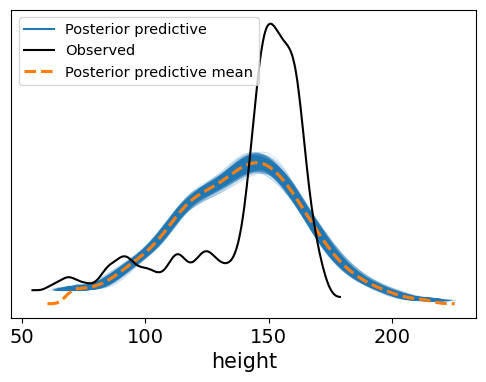

In [173]:
az.plot_ppc(idata_58, group="posterior", num_pp_samples=500);

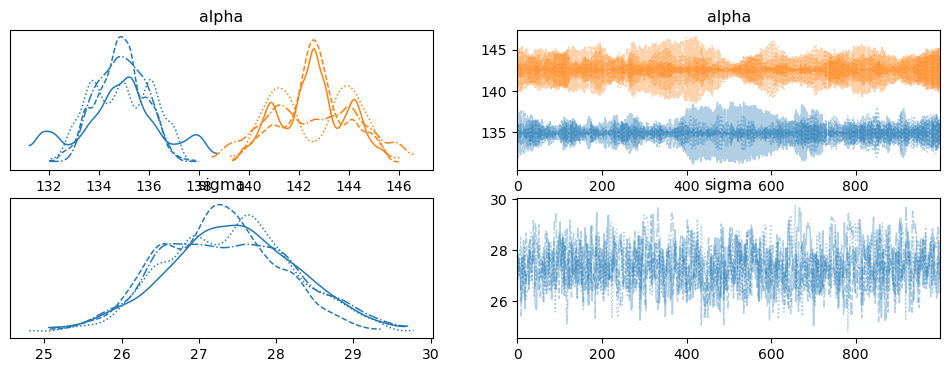

In [174]:
az.plot_trace(idata_58);

##### Code 5.48

What is the expected difference between females and males ?

We can use the samples from the posterior to compute this.

In [181]:
female_alpha = post_58_dict['alpha'][..., 0]
male_alpha = post_58_dict['alpha'][..., 1]

In [184]:
az.summary(az.from_dict({"diff_fm": female_alpha - male_alpha}), kind="stats", hdi_prob=0.89)

mean     sd  hdi_5.5%  hdi_94.5%
diff_fm -7.707  1.981   -11.078     -4.583

Note that the above computation (i.e. diff) appeared in the arviz summary. This kind of calculation is called a **CONTRAST**. 

##### Code 5.49


We explore the mile dataset again. We are now interested in `clade` variable which encodes the broad taxonomic membership of each species


In [185]:
d = RethinkingDataset.Milk.get_dataset()
d.clade.unique()

array(['Strepsirrhine', 'New World Monkey', 'Old World Monkey', 'Ape'],
      dtype=object)

In [232]:
len(d)

29

##### Code 5.50

In [186]:
d["clade_id"] = d.clade.astype("category").cat.codes
d["clade_id"]

0     3
1     3
2     3
3     3
4     3
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    2
15    2
16    2
17    2
18    2
19    2
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
Name: clade_id, dtype: int8

Based on above it seems that pandas is first sorting the categories by name and then assigning the number. So,

* Ape = 0
* New World Monkey = 1
* Old World Monkey = 2
* Strepsirrhine    = 3


##### Code 5.51

We will now model again using the index variables

In [191]:
d["K"] = d["kcal.per.g"].pipe(lambda x: (x - x.mean()) / x.std())
CLADE_LEN = len(set(d.clade_id.values))

In [192]:
def model_59(clade_id):
    def _generator():
        # the same with: tfd.Normal(loc=jnp.zeros(CLADE_LEN), scale=0.5)
        alpha = yield tfd.Sample(tfd.Normal(loc=0.0, scale=0.5), 
                                 sample_shape=CLADE_LEN, name="alpha")
        sigma = yield tfd.Exponential(rate=1.0, name="sigma")
        mu = jnp.take(alpha, clade_id)
        yield tfd.Normal(loc=mu, scale=sigma, name="K")

    return tfd.JointDistributionCoroutineAutoBatched(_generator, validate_args=True)

In [193]:
jd_59 = model_59(d.clade_id.values)

In [194]:
# added a dimension for arviz: (1, draws)
pri_59 = jd_59.sample((1, 1000), seed=a_key())

In [196]:
# assume y (output) is at the end
y_slot_59 = len(pri_59._fields) - 1
prior_59, prior_pred_59 = pri_59[: y_slot_59], pri_59[y_slot_59: ]

In [250]:
dict_59 = dict(
    prior=prior_59._asdict(), 
    prior_predictive=prior_pred_59._asdict(),
    observed_data={"K": d.K.values},
    dims={"alpha": ["clade"]},
    coords={"clade": sorted(d.clade.unique())})

In [198]:
jd_59_pd = jd_59.experimental_pin(K=d.K.values)

In [199]:
def target_log_prob_59(*states):
    return jd_59_pd.unnormalized_log_prob(states)

In [200]:
def sample_post_59(num_chains, num_results, num_burnin_steps):
    inner_kernel = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=target_log_prob_59,
        step_size=0.05,
        num_leapfrog_steps=4)
    
    kernel = tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel=inner_kernel, 
        num_adaptation_steps=int(num_burnin_steps * 0.8))
    
    init_state = jd_59_pd.sample_unpinned(num_chains, seed=a_key())

    samples = tfp.mcmc.sample_chain(
        num_results=num_results,
        current_state=init_state,
        kernel=kernel,
        num_burnin_steps=num_burnin_steps,
        trace_fn=None,
        seed=a_key())
    
    return samples

In [201]:
post_59 = sample_post_59(num_chains=4, num_results=1000, num_burnin_steps=1000)

In [202]:
post_59_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_59._asdict().items()}

In [203]:
post_pred_59 = jd_59.sample(value=post_59, seed=a_key())[y_slot_59: ]
post_pred_59_dict = {k: jnp.moveaxis(v, 0, 1) for k, v in post_pred_59._asdict().items()}

In [251]:
dict_59.update(posterior=post_59_dict,
               posterior_predictive=post_pred_59_dict)

In [252]:
idata_59 = az.from_dict(**dict_59)

In [253]:
az.summary(idata_59)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
alpha[Ape]              -0.465  0.239  -0.949   -0.062      0.004    0.003   
alpha[New World Monkey]  0.352  0.240  -0.105    0.801      0.004    0.003   
alpha[Old World Monkey]  0.639  0.278   0.055    1.115      0.005    0.004   
alpha[Strepsirrhine]    -0.552  0.297  -1.075    0.031      0.006    0.004   
sigma                    0.800  0.115   0.591    1.002      0.004    0.003   

                         ess_bulk  ess_tail  r_hat  
alpha[Ape]                 3965.0    2242.0    1.0  
alpha[New World Monkey]    4278.0    2403.0    1.0  
alpha[Old World Monkey]    2662.0    2456.0    1.0  
alpha[Strepsirrhine]       2539.0    2039.0    1.0  
sigma                       991.0    1237.0    1.0

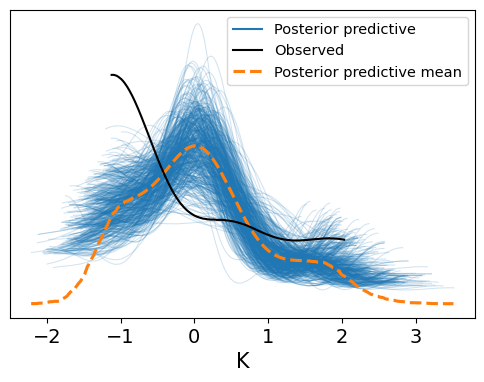

In [209]:
az.plot_ppc(idata_59, group="posterior", num_pp_samples=500);

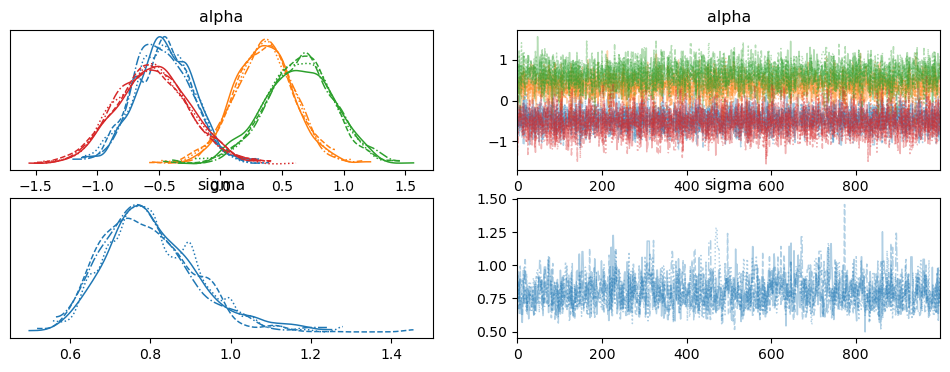

In [254]:
az.plot_trace(idata_59);

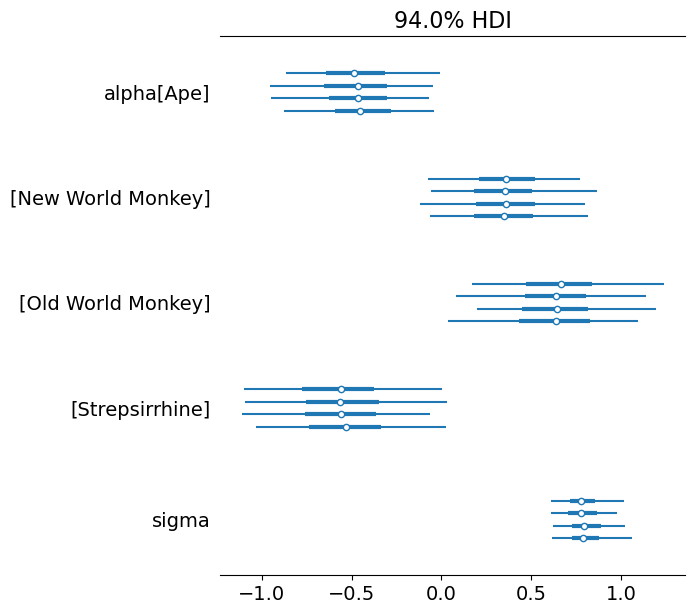

In [256]:
az.plot_forest(idata_59);